#Data preprocessing

##Load dataset

In [586]:
!pip install optuna

In [587]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler


test = pd.read_csv('/content/drive/MyDrive/dataset_horse/test.csv')
train = pd.read_csv('/content/drive/MyDrive/dataset_horse/train.csv')

## data analysis

In [588]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
surgery,yes,yes,yes,yes,no
age,adult,adult,adult,adult,adult
hospital_number,530001,533836,529812,5262541,5299629
rectal_temp,38.1,37.5,38.3,37.1,38.0
pulse,132.0,88.0,120.0,72.0,52.0
respiratory_rate,24.0,12.0,28.0,30.0,48.0
temp_of_extremities,cool,cool,cool,cold,normal
peripheral_pulse,reduced,normal,reduced,reduced,normal
mucous_membrane,dark_cyanotic,pale_cyanotic,pale_pink,pale_pink,normal_pink


In [589]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [590]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1235.0,617.000000,3.566581e+02,0.0,308.5,617.0,925.5,1234.0
hospital_number,1235.0,954500.401619,1.356403e+06,521399.0,528800.0,529777.0,534145.0,5305129.0
rectal_temp,1235.0,38.202186,7.886678e-01,35.4,37.8,38.2,38.6,40.8
pulse,1235.0,79.574089,2.910864e+01,30.0,53.0,76.0,100.0,184.0
respiratory_rate,1235.0,30.054251,1.645207e+01,8.0,18.0,28.0,36.0,96.0
nasogastric_reflux_ph,1235.0,4.382591,1.937357e+00,1.0,2.0,4.5,6.0,7.5
packed_cell_volume,1235.0,49.602429,1.053580e+01,23.0,43.0,48.0,57.0,75.0
total_protein,1235.0,21.388016,2.667645e+01,3.5,6.6,7.5,9.1,89.0
abdomo_protein,1235.0,3.290931,1.589195e+00,0.1,2.0,3.0,4.3,10.1
lesion_1,1235.0,3832.496356,5.436734e+03,0.0,2205.0,2209.0,3205.0,41110.0


In [591]:
train.drop(['hospital_number', 'lesion_2', 'lesion_3'], axis = 1, inplace = True)
test.drop(['hospital_number', 'lesion_2', 'lesion_3'], axis = 1, inplace = True)


In [592]:
train_pre = train.copy()
test_pre = test.copy()

In [593]:
cat_cols = train_pre.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('outcome')
print(cat_cols)

['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']


In [594]:
num_cols = train_pre.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('id')
print(num_cols)

['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1']


<ipython-input-595-1286d0dab497>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette='hls')


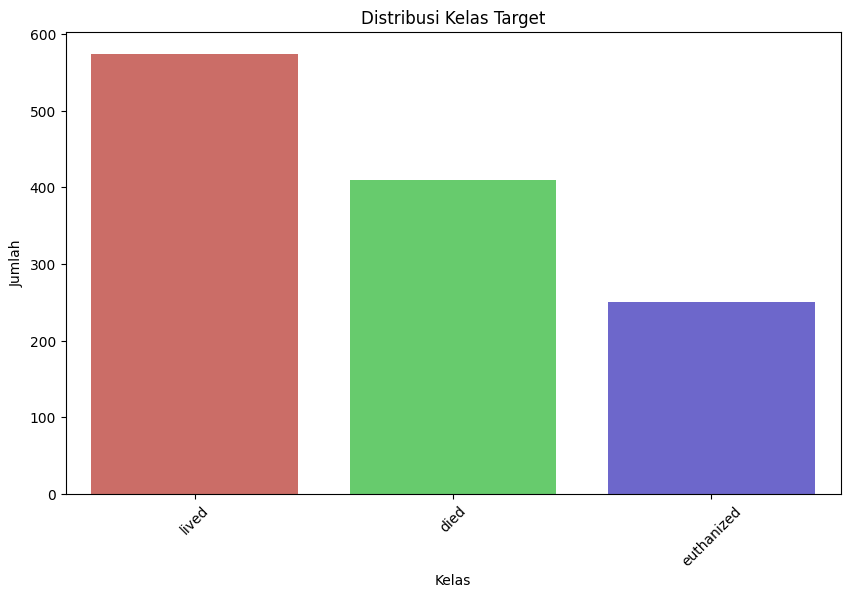

In [595]:
# Data distribusi kelas target
target_counts = train['outcome'].value_counts()

# Buat plot dengan palet warna berbeda
plt.figure(figsize=(10, 6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='hls')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.title('Distribusi Kelas Target')
plt.xticks(rotation=45)
plt.show()


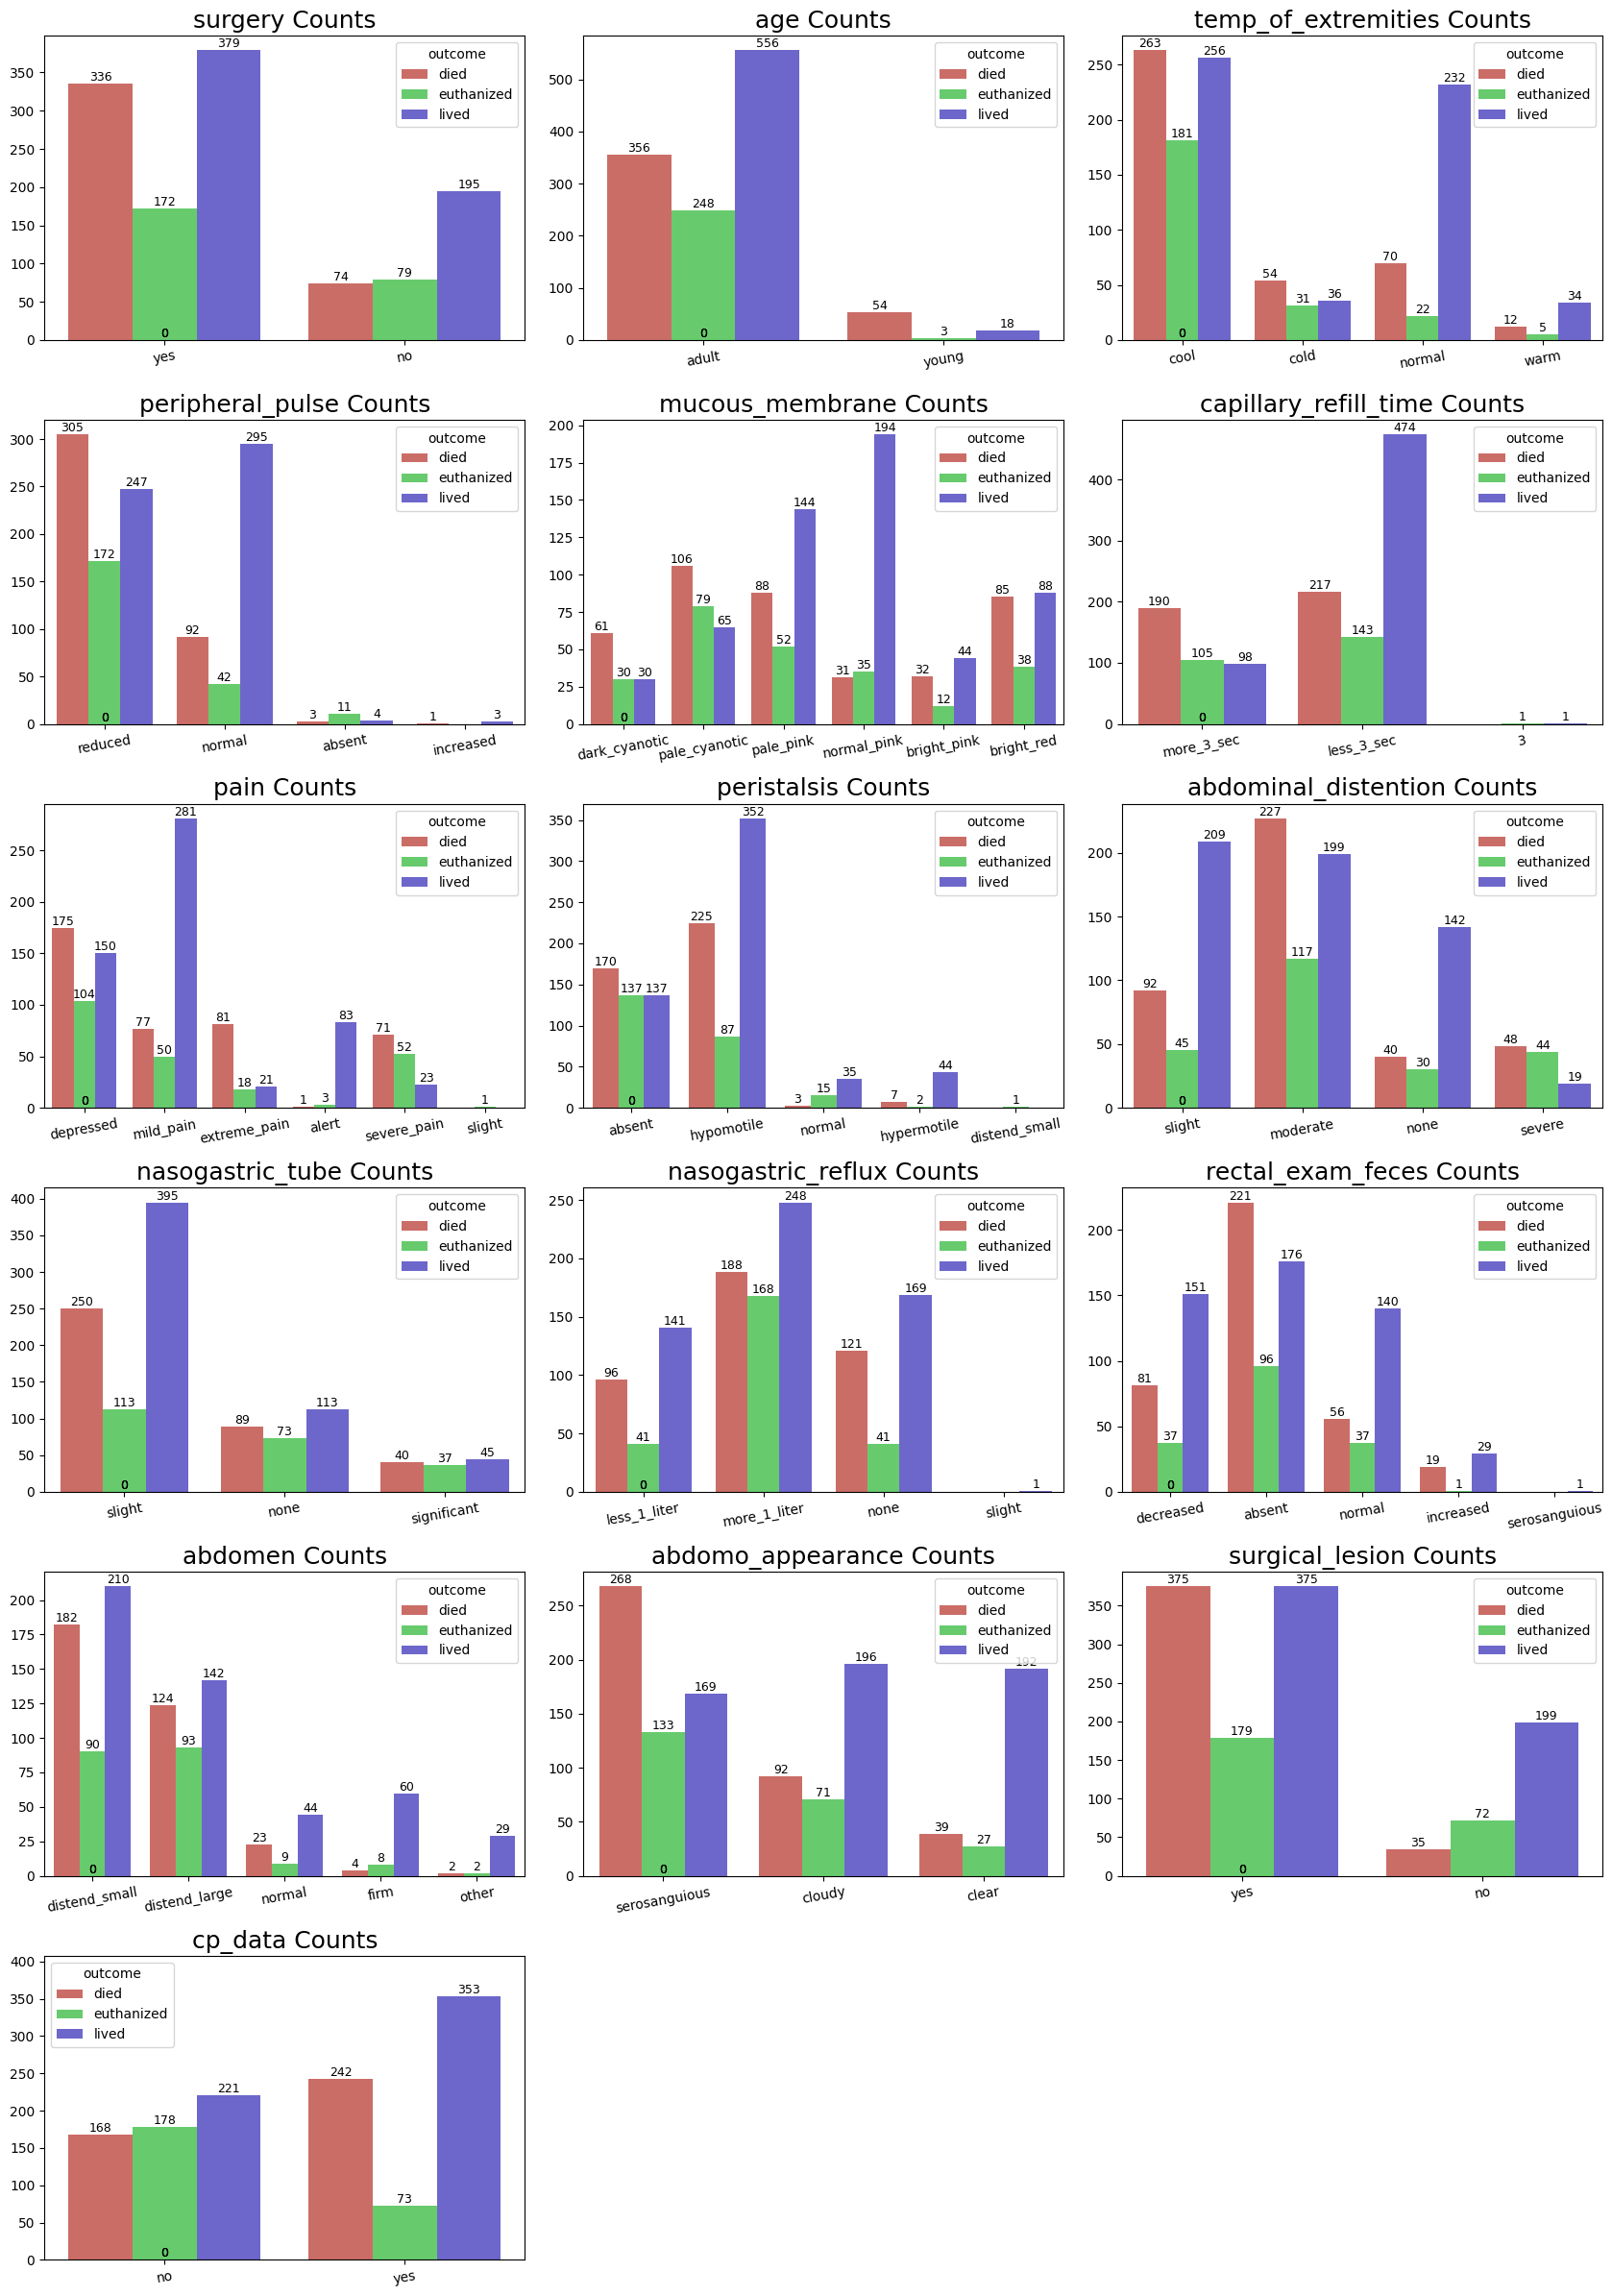

In [596]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count(df, columns, n_cols, hue):
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i],palette='hls', hue='outcome')

        # Titles and labels
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=10)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Panggil fungsi dengan data train, kolom kategori, 3 kolom per baris, dan hue='outcome'
plot_count(train, cat_cols, 3, 'outcome')


In [597]:
train_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  naso

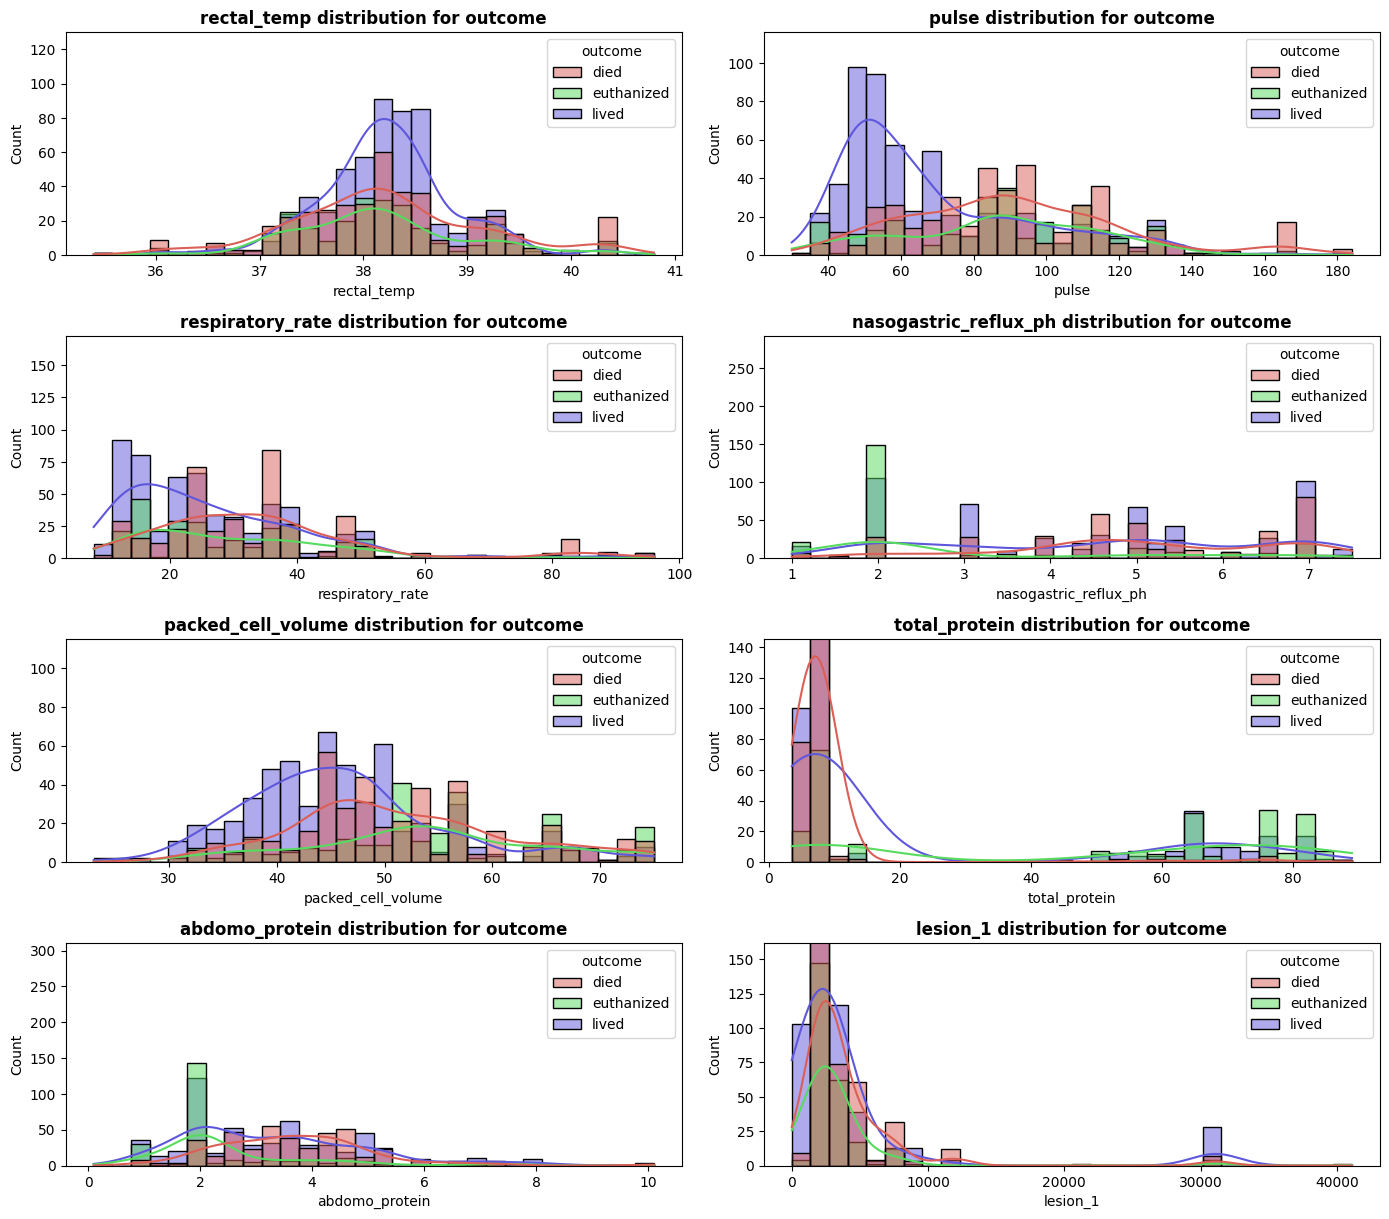

In [598]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
data = train_pre[num_cols]

# Create histograms with 'hls' color palette
plt.figure(figsize=(14, len(num_cols) * 3))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 2, i+1)
    sns.histplot(x=col, hue="outcome", data=train_pre, bins=30, kde=True, palette='hls')
    plt.title(f"{col} distribution for outcome", fontweight="bold")
    plt.ylim(0, train_pre[col].value_counts().max() + 10)

plt.tight_layout()
plt.show()


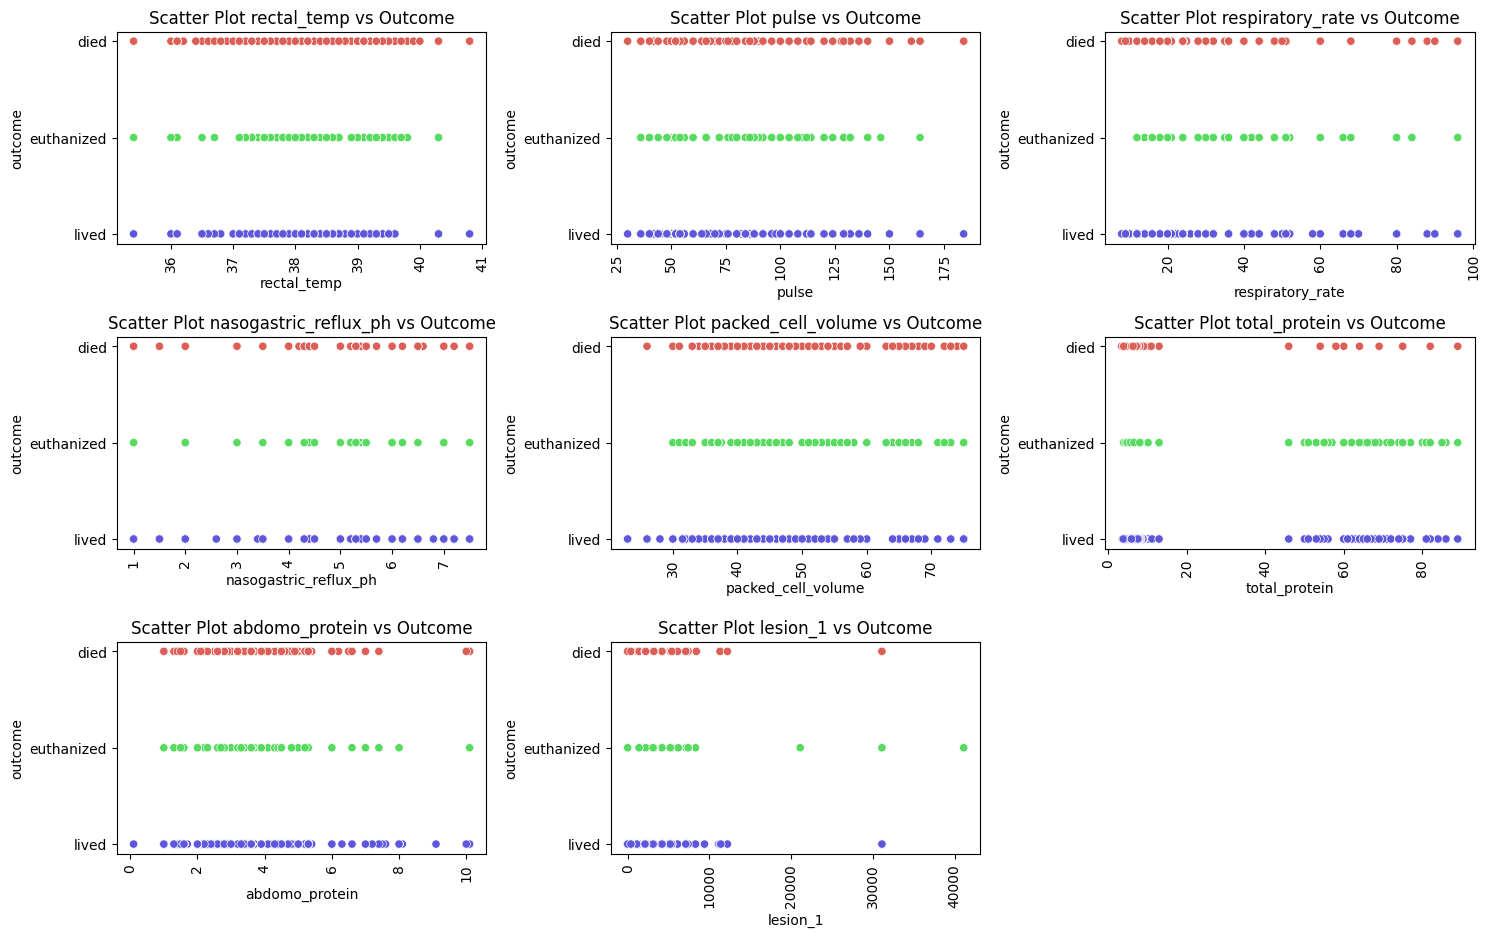

In [599]:
data = train_pre[num_cols]

plt.figure(figsize=(15, len(num_cols)*3))
for idx, column in enumerate(num_cols):
    plt.subplot(len(num_cols), 3, idx+1)
    sns.scatterplot(data=data, x=column, y=train_pre['outcome'], palette='hls', hue=train['outcome'], legend=False)
    plt.xticks(rotation=90)
    plt.title(f"Scatter Plot {column} vs Outcome")
    plt.tight_layout()
plt.show()


In [600]:
print(train_pre.columns)


Index(['id', 'surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
       'abdomo_appearance', 'abdomo_protein', 'surgical_lesion', 'lesion_1',
       'cp_data', 'outcome'],
      dtype='object')


In [601]:
def unique(data):
    unique_values = data.unique()
    value_counts = data.value_counts()
    print(f'Nilai unik: {unique_values}', f'Jumlah: {value_counts}')

In [602]:
def missing(data):
  print(data.isnull().sum())

In [603]:
missing(train_pre)

id                         0
surgery                    0
age                        0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
cp_data                    0
outcome                    0
dtype: int64


In [604]:
import pandas as pd

# Contoh data (gantilah dengan data sesuai kebutuhan)
data = train_pre

df = pd.DataFrame(data)

# Menghitung jumlah nilai yang hilang per fitur
missing_counts = df.isnull().sum()

# Membuat tabel untuk fitur dengan nilai yang hilang
missing_table = pd.DataFrame({'Feature': missing_counts.index, 'Missing Count': missing_counts.values})
missing_table = missing_table[missing_table['Missing Count'] > 0]  # Hanya tampilkan yang memiliki nilai hilang

print(missing_table)


                  Feature  Missing Count
6     temp_of_extremities             39
7        peripheral_pulse             60
8         mucous_membrane             21
9   capillary_refill_time              6
10                   pain             44
11            peristalsis             20
12   abdominal_distention             23
13       nasogastric_tube             80
14     nasogastric_reflux             21
16      rectal_exam_feces            190
17                abdomen            213
20      abdomo_appearance             48


<Figure size 1000x600 with 0 Axes>

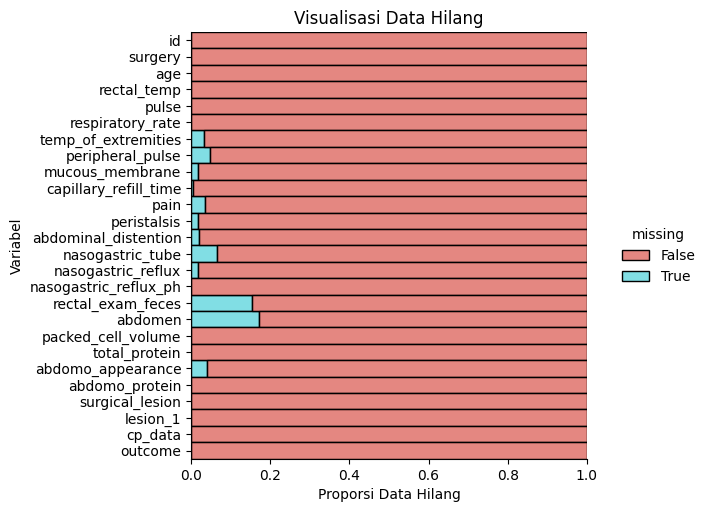

In [605]:
plt.figure(figsize=(10, 6))
sns.displot(data=data.isna().melt(value_name="missing"), y="variable", hue="missing", palette = 'hls', multiple="fill", aspect=1.25)
plt.title("Visualisasi Data Hilang")
plt.xlabel('Proporsi Data Hilang')
plt.ylabel('Variabel')
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)


In [606]:
train_pre.duplicated().sum()

0

In [607]:
def check_inconsistency(train_data, test_data):
    for col in train_data.select_dtypes(include = 'object').columns:
      if col != 'outcome':
        train_unique_values = set(train_data[col].unique())
        test_unique_values = set(test_data[col].unique())
        in_train_not_test = train_unique_values - test_unique_values
        in_test_not_train = test_unique_values - train_unique_values

        if in_train_not_test:
            print(f'Nilai di kolom {col} yang ada di data train tetapi tidak ada di data test: {in_train_not_test}')
        if in_test_not_train:
            print(f'Nilai di kolom {col} yang ada di data test tetapi tidak ada di data train: {in_test_not_train}')


In [608]:
check_inconsistency(train_pre, test_pre)

Nilai di kolom pain yang ada di data train tetapi tidak ada di data test: {'slight'}
Nilai di kolom pain yang ada di data test tetapi tidak ada di data train: {'moderate'}
Nilai di kolom peristalsis yang ada di data train tetapi tidak ada di data test: {'distend_small'}
Nilai di kolom nasogastric_reflux yang ada di data train tetapi tidak ada di data test: {'slight'}
Nilai di kolom rectal_exam_feces yang ada di data train tetapi tidak ada di data test: {'serosanguious'}


#Preprocessing

## data cleaning

In [609]:
missing_cols = train_pre.columns[train.isnull().any()].tolist()
print(missing_cols)

['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance']


In [610]:
# train_pre['outcome'] = train_pre['outcome'].map({'euthanized':0,'died':1,'lived':2 })

In [611]:
unique(train_pre['pain'])
unique(test_pre['pain'])
unique(train_pre['peristalsis'])
unique(train_pre['nasogastric_reflux'])
unique(train_pre['rectal_exam_feces'])

Nilai unik: ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight'] Jumlah: pain
depressed       429
mild_pain       408
severe_pain     146
extreme_pain    120
alert            87
slight            1
Name: count, dtype: int64
Nilai unik: ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' nan 'moderate'
 'alert'] Jumlah: pain
depressed       310
mild_pain       255
severe_pain     115
extreme_pain     82
alert            32
moderate          1
Name: count, dtype: int64
Nilai unik: ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small'] Jumlah: peristalsis
hypomotile       664
absent           444
normal            53
hypermotile       53
distend_small      1
Name: count, dtype: int64
Nilai unik: ['less_1_liter' 'more_1_liter' 'none' nan 'slight'] Jumlah: nasogastric_reflux
more_1_liter    604
none            331
less_1_liter    278
slight            1
Name: count, dtype: int64
Nilai unik: ['decreased' 'absent' nan 'normal' 'increased' 'serosanguious'] 

In [612]:
train_pre["pain"] = np.where(train_pre["pain"].isin(["slight"]), "mild_pain", train_pre["pain"])

train_pre["peristalsis"] = np.where(train_pre["peristalsis"].isin(["distend_small"]), train_pre["peristalsis"].mode()[0], train_pre["peristalsis"])

train_pre["rectal_exam_feces"] = np.where(train_pre["rectal_exam_feces"].isin(["serosanguious"]), train_pre["rectal_exam_feces"].mode()[0], train_pre["rectal_exam_feces"])

train_pre["nasogastric_reflux"] = np.where(train_pre["nasogastric_reflux"].isin(["slight"]), train_pre["nasogastric_reflux"].mode()[0], train_pre["nasogastric_reflux"])

In [613]:
check_inconsistency(train_pre, test_pre)

Nilai di kolom pain yang ada di data test tetapi tidak ada di data train: {'moderate'}


### One hot

In [614]:
# onehot_train = train_pre.copy()
# onehot_test = test_pre.copy()

In [615]:
# from sklearn.preprocessing import OneHotEncoder

# onehot_cols = ['surgery', 'age', 'surgical_lesion', 'cp_data']
# encoder = OneHotEncoder(sparse=False)

# def onehot(data):
#   for col in onehot_cols:
#     onehot_arr = encoder.fit_transform(data[[col]])
#     onehot_df = pd.DataFrame(onehot_arr, columns = [f"{col}_{cat}" for cat in encoder.categories_[0]])

#     data = data.drop(col, axis = 1)
#     data = pd.concat([data, onehot_df], axis = 1)
#   return data

# onehot_train = onehot(onehot_train)
# onehot_test = onehot(onehot_test)

### Label encoding

In [616]:
train_labelenc = train_pre.copy()
test_labelenc = test_pre.copy()

In [617]:
cat_cols = train_labelenc.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('outcome')
print(cat_cols)

['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']


In [618]:
missing_cols = train_labelenc.columns[train_labelenc.isnull().any()].tolist()
print(missing_cols)

['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance']


In [619]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

for col in missing_cols:
  train_labelenc[col].fillna('missing', inplace=True)
  test_labelenc[col].fillna('missing', inplace=True)

def missing_labelencoder(data):
    encoder = LabelEncoder()
    for col in missing_cols:
        # Fit the encoder on the data
        encoder.fit(data[col])
        # Transform the data
        data[col] = encoder.transform(data[col])
        # Replace 'missing' with np.nan
        data[col] = data[col].replace(encoder.transform(['missing'])[0], np.nan)
    return data


In [620]:
missing_labelencoder(train_labelenc)
missing_labelencoder(test_labelenc)


,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
0,1235,no,adult,38.6,40.0,20.0,3.0,3.0,4.0,1.0,...,7.0,4.0,1.0,42.0,7.5,0.0,2.3,no,0,no
1,1236,yes,adult,38.2,112.0,48.0,1.0,4.0,0.0,3.0,...,3.5,1.0,1.0,44.0,6.0,3.0,2.6,no,2208,yes
2,1237,yes,adult,37.7,66.0,12.0,1.0,3.0,1.0,1.0,...,3.0,4.0,1.0,31.5,6.0,1.0,1.6,yes,2205,yes
3,1238,no,adult,37.1,88.0,20.0,1.0,4.0,5.0,1.0,...,2.0,0.0,0.0,75.0,81.0,NaN,1.0,yes,1400,no
4,1239,yes,adult,38.3,50.0,12.0,NaN,3.0,0.0,1.0,...,3.0,1.0,1.0,37.0,6.8,1.0,2.6,yes,2208,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,no,adult,40.3,114.0,36.0,1.0,4.0,4.0,3.0,...,7.0,4.0,0.0,57.0,8.1,3.0,4.5,yes,3205,yes
820,2055,yes,adult,37.2,100.0,20.0,1.0,4.0,5.0,3.0,...,2.0,0.0,1.0,50.0,66.0,3.0,2.0,yes,2209,no
821,2056,yes,adult,39.2,132.0,12.0,1.0,4.0,2.0,3.0,...,6.5,1.0,NaN,53.0,7.6,3.0,4.5,yes,2205,no
822,2057,no,adult,38.3,54.0,66.0,3.0,3.0,4.0,1.0,...,7.0,4.0,NaN,49.0,8.6,0.0,5.0,no,3111,yes


In [621]:
cat_cols = train_labelenc.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('outcome')
print(cat_cols)

['surgery', 'age', 'surgical_lesion', 'cp_data']


In [622]:
encoder = LabelEncoder()
def labelencoder(data):
  for col in cat_cols:
    encoder.fit(data[col])
    data[col] = encoder.transform(data[col])
  return data


In [623]:
labelencoder(train_labelenc)
labelencoder(test_labelenc)

,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
0,1235,0,0,38.6,40.0,20.0,3.0,3.0,4.0,1.0,...,7.0,4.0,1.0,42.0,7.5,0.0,2.3,0,0,0
1,1236,1,0,38.2,112.0,48.0,1.0,4.0,0.0,3.0,...,3.5,1.0,1.0,44.0,6.0,3.0,2.6,0,2208,1
2,1237,1,0,37.7,66.0,12.0,1.0,3.0,1.0,1.0,...,3.0,4.0,1.0,31.5,6.0,1.0,1.6,1,2205,1
3,1238,0,0,37.1,88.0,20.0,1.0,4.0,5.0,1.0,...,2.0,0.0,0.0,75.0,81.0,NaN,1.0,1,1400,0
4,1239,1,0,38.3,50.0,12.0,NaN,3.0,0.0,1.0,...,3.0,1.0,1.0,37.0,6.8,1.0,2.6,1,2208,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0,0,40.3,114.0,36.0,1.0,4.0,4.0,3.0,...,7.0,4.0,0.0,57.0,8.1,3.0,4.5,1,3205,1
820,2055,1,0,37.2,100.0,20.0,1.0,4.0,5.0,3.0,...,2.0,0.0,1.0,50.0,66.0,3.0,2.0,1,2209,0
821,2056,1,0,39.2,132.0,12.0,1.0,4.0,2.0,3.0,...,6.5,1.0,NaN,53.0,7.6,3.0,4.5,1,2205,0
822,2057,0,0,38.3,54.0,66.0,3.0,3.0,4.0,1.0,...,7.0,4.0,NaN,49.0,8.6,0.0,5.0,0,3111,1


In [624]:
train_labelenc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   int64  
 2   age                    1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   float64
 7   peripheral_pulse       1175 non-null   float64
 8   mucous_membrane        1214 non-null   float64
 9   capillary_refill_time  1229 non-null   float64
 10  pain                   1191 non-null   float64
 11  peristalsis            1215 non-null   float64
 12  abdominal_distention   1212 non-null   float64
 13  nasogastric_tube       1155 non-null   float64
 14  nasogastric_reflux     1214 non-null   float64
 15  naso

### Imputasi

In [625]:
train_impute = train_labelenc.copy()
test_impute = test_labelenc.copy()

In [626]:
missing(train_impute)

id                         0
surgery                    0
age                        0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
cp_data                    0
outcome                    0
dtype: int64


In [627]:
missing_cols = train_labelenc.columns[train_labelenc.isnull().any()].tolist()
print(missing_cols)

['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance']


In [628]:
from sklearn.impute import KNNImputer

def knn_imputer(data, n_neighbors=10):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    data[missing_cols] = imputer.fit_transform(data[missing_cols])
    return data

knn_imputer(train_impute)
knn_imputer(test_impute)

,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
0,1235,0,0,38.6,40.0,20.0,3.0,3.0,4.0,1.0,...,7.0,4.0,1.0,42.0,7.5,0.0,2.3,0,0,0
1,1236,1,0,38.2,112.0,48.0,1.0,4.0,0.0,3.0,...,3.5,1.0,1.0,44.0,6.0,3.0,2.6,0,2208,1
2,1237,1,0,37.7,66.0,12.0,1.0,3.0,1.0,1.0,...,3.0,4.0,1.0,31.5,6.0,1.0,1.6,1,2205,1
3,1238,0,0,37.1,88.0,20.0,1.0,4.0,5.0,1.0,...,2.0,0.0,0.0,75.0,81.0,1.8,1.0,1,1400,0
4,1239,1,0,38.3,50.0,12.0,1.8,3.0,0.0,1.0,...,3.0,1.0,1.0,37.0,6.8,1.0,2.6,1,2208,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0,0,40.3,114.0,36.0,1.0,4.0,4.0,3.0,...,7.0,4.0,0.0,57.0,8.1,3.0,4.5,1,3205,1
820,2055,1,0,37.2,100.0,20.0,1.0,4.0,5.0,3.0,...,2.0,0.0,1.0,50.0,66.0,3.0,2.0,1,2209,0
821,2056,1,0,39.2,132.0,12.0,1.0,4.0,2.0,3.0,...,6.5,1.0,0.6,53.0,7.6,3.0,4.5,1,2205,0
822,2057,0,0,38.3,54.0,66.0,3.0,3.0,4.0,1.0,...,7.0,4.0,1.7,49.0,8.6,0.0,5.0,0,3111,1


In [629]:
missing(train_impute)

id                       0
surgery                  0
age                      0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
cp_data                  0
outcome                  0
dtype: int64


##feature scaling

In [630]:
cols_toscaled = ['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate',
                 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
                 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
                 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
                 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
                 'abdomo_appearance', 'abdomo_protein', 'surgical_lesion', 'lesion_1', 'cp_data']


In [631]:
# cols_toscaled = ['rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance', 'abdomo_protein', 'lesion_1', 'surgery_no', 'surgery_yes', 'age_adult', 'age_young', 'surgical_lesion_no', 'surgical_lesion_yes', 'cp_data_no', 'cp_data_yes']


In [684]:
def visualization(data, cols):
    plt.figure(figsize=(16,10))
    data_to_plot = [data[col] for col in cols]
    plt.boxplot(data_to_plot, vert=False, patch_artist=True)
    plt.yticks(range(1, len(cols) + 1), cols)
    plt.title('Boxplot Semua Fitur')
    plt.xlabel('Range')
    plt.ylabel('Features')
    plt.show()


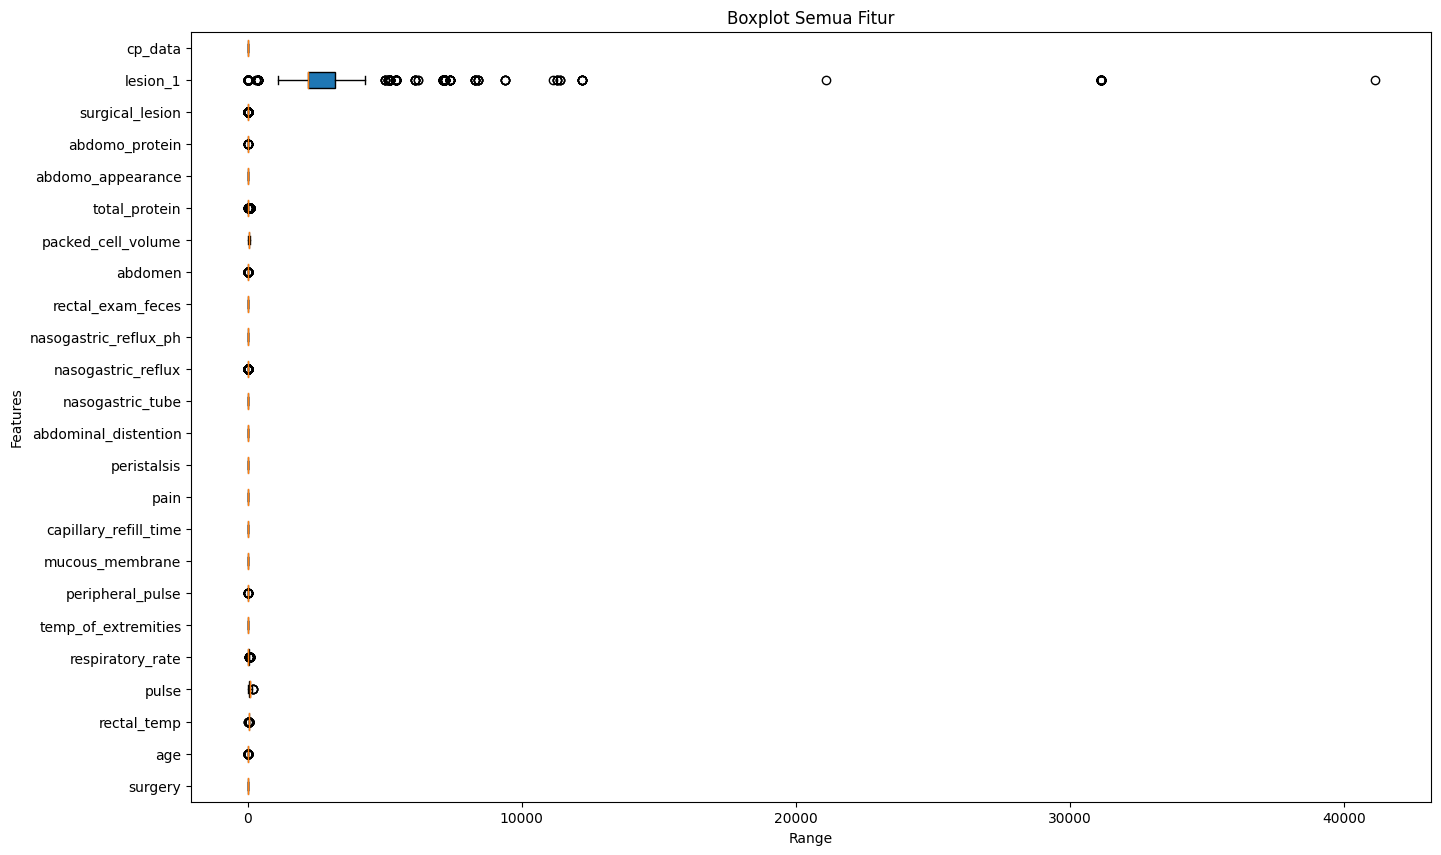

In [693]:
visualization(train_impute, cols_toscaled)

### minmax

In [632]:
train_minmax = train_impute.copy()
test_minmax = test_impute.copy()

In [633]:
# train_impute.info()

In [634]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def scalerminmax(data):
  for col in cols_toscaled:
    data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
  return data

In [635]:
scalerminmax(train_minmax)
scalerminmax(test_minmax)

,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
0,1235,0.0,0.0,0.541667,0.027027,0.126437,0.75,0.75,0.666667,0.333333,...,0.923077,1.00,0.20,0.365385,0.042303,0.000000,0.22,0.0,0.000000,0.0
1,1236,1.0,0.0,0.458333,0.513514,0.448276,0.25,1.00,0.000000,1.000000,...,0.384615,0.25,0.20,0.403846,0.024677,1.000000,0.25,0.0,0.070974,1.0
2,1237,1.0,0.0,0.354167,0.202703,0.034483,0.25,0.75,0.166667,0.333333,...,0.307692,1.00,0.20,0.163462,0.024677,0.333333,0.15,1.0,0.070878,1.0
3,1238,0.0,0.0,0.229167,0.351351,0.126437,0.25,1.00,0.833333,0.333333,...,0.153846,0.00,0.00,1.000000,0.905993,0.600000,0.09,1.0,0.045002,0.0
4,1239,1.0,0.0,0.479167,0.094595,0.034483,0.45,0.75,0.000000,0.333333,...,0.307692,0.25,0.20,0.269231,0.034078,0.333333,0.25,1.0,0.070974,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0.0,0.0,0.895833,0.527027,0.310345,0.25,1.00,0.666667,1.000000,...,0.923077,1.00,0.00,0.653846,0.049354,1.000000,0.44,1.0,0.103022,1.0
820,2055,1.0,0.0,0.250000,0.432432,0.126437,0.25,1.00,0.833333,1.000000,...,0.153846,0.00,0.20,0.519231,0.729730,1.000000,0.19,1.0,0.071006,0.0
821,2056,1.0,0.0,0.666667,0.648649,0.034483,0.25,1.00,0.333333,1.000000,...,0.846154,0.25,0.12,0.576923,0.043478,1.000000,0.44,1.0,0.070878,0.0
822,2057,0.0,0.0,0.479167,0.121622,0.655172,0.75,0.75,0.666667,0.333333,...,0.923077,1.00,0.34,0.500000,0.055229,0.000000,0.49,0.0,0.100000,1.0


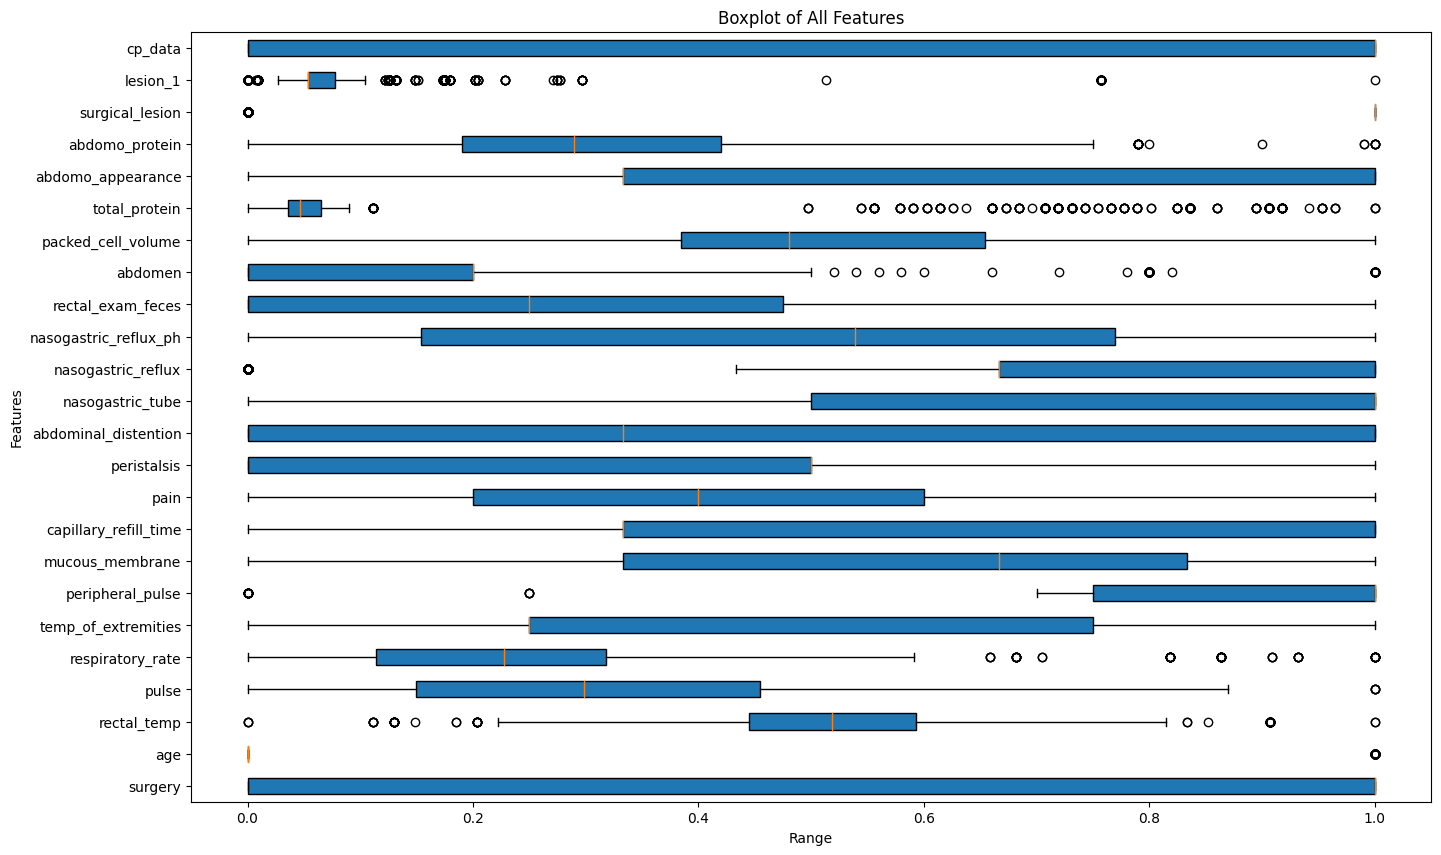

In [683]:
visualization(train_minmax, cols_toscaled)

### zscore

In [636]:
# train_log.describe().T

In [690]:
# train_zscore = train_impute.copy()
# test_zscore = test_impute.copy()
# num_cols = train_impute.select_dtypes(include=['float64', 'int64']).columns

In [691]:
# from sklearn.preprocessing import StandardScaler

# zscaler = StandardScaler()

# def zscore_scaling(data):
#   for col in num_cols:
#     data[col] = zscaler.fit_transform(data[col].values.reshape(-1, 1))
#   return data

# zscore_scaling(train_zscore)
# zscore_scaling(test_zscore)

,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
0,1235,0,0,0.452957,-1.380223,-0.615318,3.0,3.0,4.0,1.0,...,1.323635,4.0,1.0,-0.676320,-0.503692,0.0,-0.673744,0,-0.726013,0
1,1236,1,0,-0.056755,1.090013,0.991907,1.0,4.0,0.0,3.0,...,-0.535772,1.0,1.0,-0.484819,-0.560515,3.0,-0.478723,0,-0.293905,1
2,1237,1,0,-0.693895,-0.488193,-1.074525,1.0,3.0,1.0,1.0,...,-0.801402,4.0,1.0,-1.681702,-0.560515,1.0,-1.128791,1,-0.294492,1
3,1238,0,0,-1.458462,0.266601,-0.615318,1.0,4.0,5.0,1.0,...,-1.332661,0.0,0.0,2.483451,2.280657,1.8,-1.518832,1,-0.452032,0
4,1239,1,0,0.070673,-1.037135,-1.074525,1.8,3.0,0.0,1.0,...,-0.801402,1.0,1.0,-1.155073,-0.530210,1.0,-0.478723,1,-0.293905,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0,0,2.619232,1.158631,0.303096,1.0,4.0,4.0,3.0,...,1.323635,4.0,0.0,0.759939,-0.480963,3.0,0.756406,1,-0.098791,1
820,2055,1,0,-1.331034,0.678307,-0.615318,1.0,4.0,5.0,3.0,...,-1.332661,0.0,1.0,0.089685,1.712422,3.0,-0.868764,1,-0.293709,0
821,2056,1,0,1.217524,1.776190,-1.074525,1.0,4.0,2.0,3.0,...,1.058005,1.0,0.6,0.376937,-0.499904,3.0,0.756406,1,-0.294492,0
822,2057,0,0,0.070673,-0.899899,2.025123,3.0,3.0,4.0,1.0,...,1.323635,4.0,1.7,-0.006066,-0.462021,0.0,1.081440,0,-0.117187,1


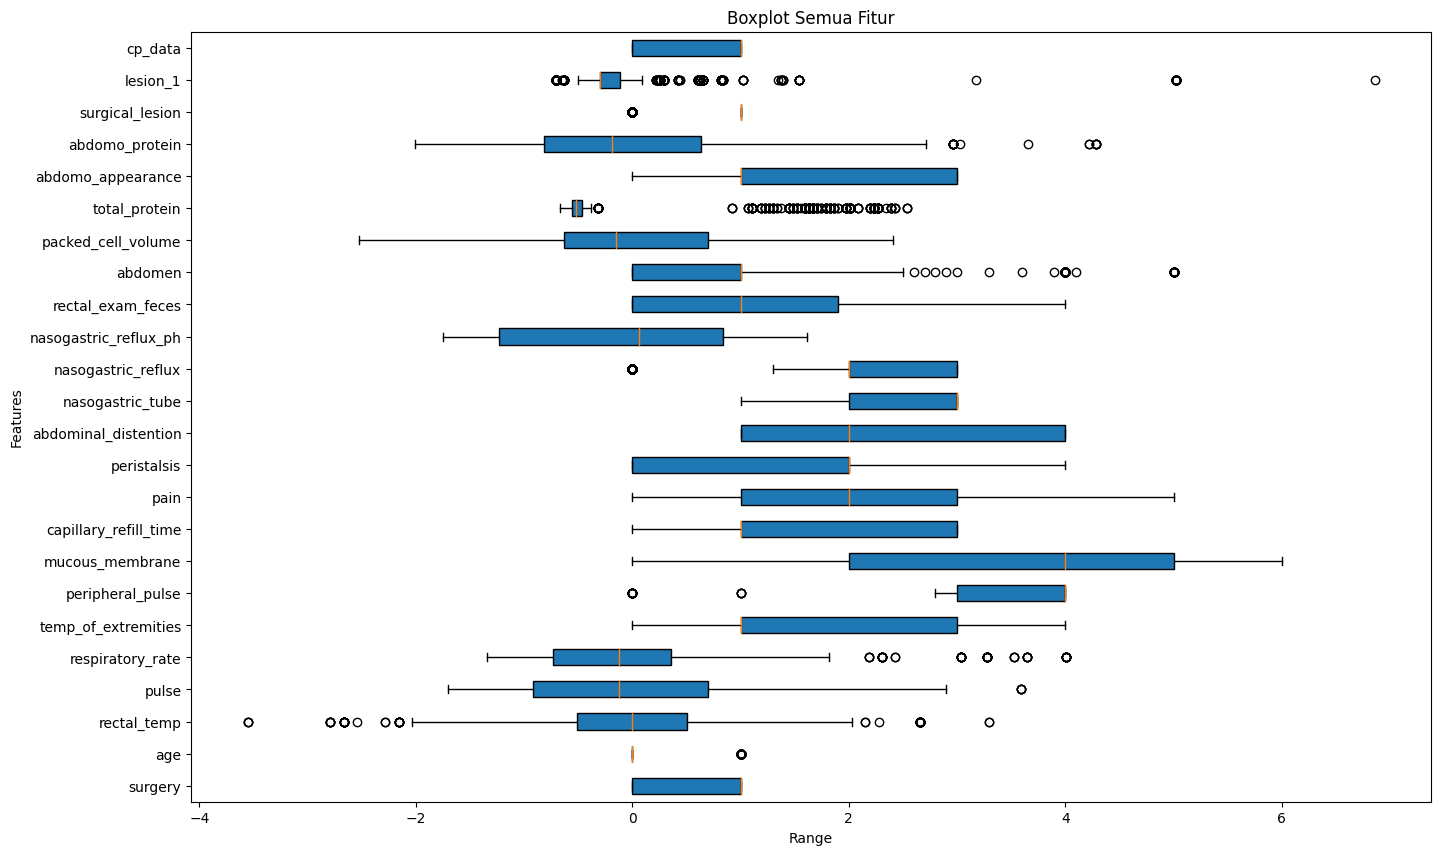

In [692]:
# visualization(train_zscore, cols_toscaled)

### Robust Scaler

In [687]:
# train_robust = train_impute.copy()
# test_robust = test_impute.copy()

In [688]:
# from sklearn.preprocessing import RobustScaler

# def robust_scaler(data, cols_toscaled):
#     scaler = RobustScaler()

#     for col in cols_toscaled:
#         data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))

#     return data

# robust_scaler(train_robust, cols_toscaled)
# robust_scaler(test_robust, cols_toscaled)

,id,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data
0,1235,-1.0,0.0,0.500,-0.782609,-0.444444,1.0,-1.0,0.000000,0.0,...,0.714286,1.5,0.0,-0.500000,0.000000,-0.60,-0.434783,-1.0,-2.209,-1.0
1,1236,0.0,0.0,0.000,0.782609,1.111111,0.0,0.0,-1.333333,1.0,...,-0.285714,0.0,0.0,-0.333333,-0.652174,0.90,-0.304348,-1.0,-0.001,0.0
2,1237,0.0,0.0,-0.625,-0.217391,-0.888889,0.0,-1.0,-1.000000,0.0,...,-0.428571,1.5,0.0,-1.375000,-0.652174,-0.10,-0.739130,0.0,-0.004,0.0
3,1238,-1.0,0.0,-1.375,0.260870,-0.444444,0.0,0.0,0.333333,0.0,...,-0.714286,-0.5,-1.0,2.250000,31.956522,0.30,-1.000000,0.0,-0.809,-1.0
4,1239,0.0,0.0,0.125,-0.565217,-0.888889,0.4,-1.0,-1.333333,0.0,...,-0.428571,0.0,0.0,-0.916667,-0.304348,-0.10,-0.304348,0.0,-0.001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,-1.0,0.0,2.625,0.826087,0.444444,0.0,0.0,0.000000,1.0,...,0.714286,1.5,-1.0,0.750000,0.260870,0.90,0.521739,0.0,0.996,0.0
820,2055,0.0,0.0,-1.250,0.521739,-0.444444,0.0,0.0,0.333333,1.0,...,-0.714286,-0.5,0.0,0.166667,25.434783,0.90,-0.565217,0.0,0.000,-1.0
821,2056,0.0,0.0,1.250,1.217391,-0.888889,0.0,0.0,-0.666667,1.0,...,0.571429,0.0,-0.4,0.416667,0.043478,0.90,0.521739,0.0,-0.004,-1.0
822,2057,-1.0,0.0,0.125,-0.478261,2.111111,1.0,-1.0,0.000000,0.0,...,0.714286,1.5,0.7,0.083333,0.478261,-0.60,0.739130,-1.0,0.902,0.0


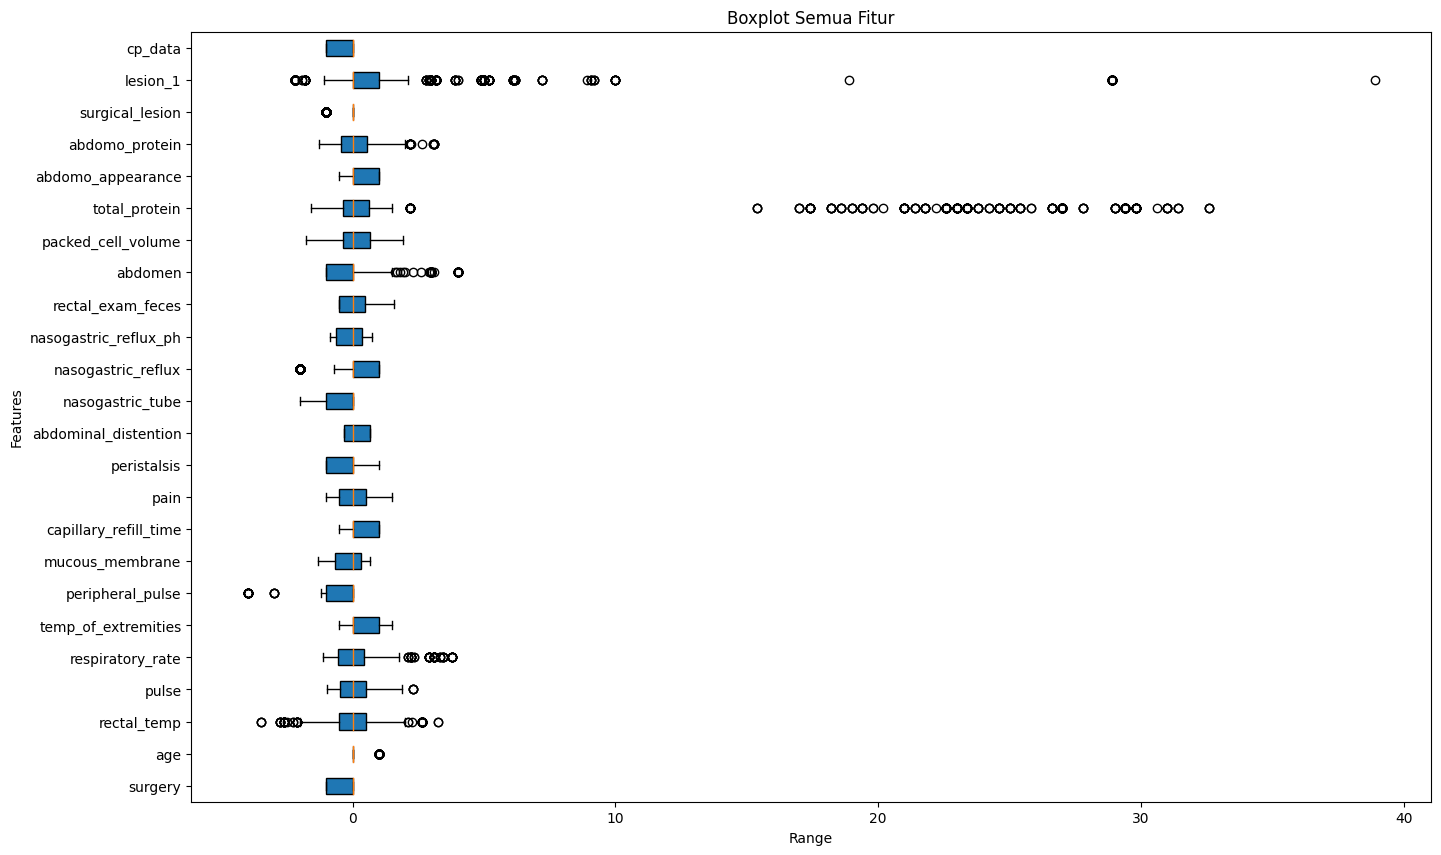

In [689]:
# visualization(train_robust, cols_toscaled)

#model


## Preparation

In [641]:
train_minmax["outcome"] = train_minmax["outcome"].map({'euthanized':0,'died':1,'lived':2 })


In [642]:
train_minmax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   float64
 2   age                    1235 non-null   float64
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1235 non-null   float64
 7   peripheral_pulse       1235 non-null   float64
 8   mucous_membrane        1235 non-null   float64
 9   capillary_refill_time  1235 non-null   float64
 10  pain                   1235 non-null   float64
 11  peristalsis            1235 non-null   float64
 12  abdominal_distention   1235 non-null   float64
 13  nasogastric_tube       1235 non-null   float64
 14  nasogastric_reflux     1235 non-null   float64
 15  naso

In [643]:
# Memisahkan atribut pada dataset
X_train = train_minmax[train_minmax.columns[1:25]]
y_train = train_minmax['outcome']

X_test = test_minmax[test_minmax.columns[1:25]]

In [644]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   float64
 1   age                    1235 non-null   float64
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   float64
 6   peripheral_pulse       1235 non-null   float64
 7   mucous_membrane        1235 non-null   float64
 8   capillary_refill_time  1235 non-null   float64
 9   pain                   1235 non-null   float64
 10  peristalsis            1235 non-null   float64
 11  abdominal_distention   1235 non-null   float64
 12  nasogastric_tube       1235 non-null   float64
 13  nasogastric_reflux     1235 non-null   float64
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

In [645]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    float64
 1   age                    824 non-null    float64
 2   rectal_temp            824 non-null    float64
 3   pulse                  824 non-null    float64
 4   respiratory_rate       824 non-null    float64
 5   temp_of_extremities    824 non-null    float64
 6   peripheral_pulse       824 non-null    float64
 7   mucous_membrane        824 non-null    float64
 8   capillary_refill_time  824 non-null    float64
 9   pain                   824 non-null    float64
 10  peristalsis            824 non-null    float64
 11  abdominal_distention   824 non-null    float64
 12  nasogastric_tube       824 non-null    float64
 13  nasogastric_reflux     824 non-null    float64
 14  nasogastric_reflux_ph  824 non-null    float64
 15  rectal

In [646]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1235 entries, 0 to 1234
Series name: outcome
Non-Null Count  Dtype
--------------  -----
1235 non-null   int64
dtypes: int64(1)
memory usage: 9.8 KB


## Not optimized

In [647]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   float64
 1   age                    1235 non-null   float64
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1235 non-null   float64
 6   peripheral_pulse       1235 non-null   float64
 7   mucous_membrane        1235 non-null   float64
 8   capillary_refill_time  1235 non-null   float64
 9   pain                   1235 non-null   float64
 10  peristalsis            1235 non-null   float64
 11  abdominal_distention   1235 non-null   float64
 12  nasogastric_tube       1235 non-null   float64
 13  nasogastric_reflux     1235 non-null   float64
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

In [648]:
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

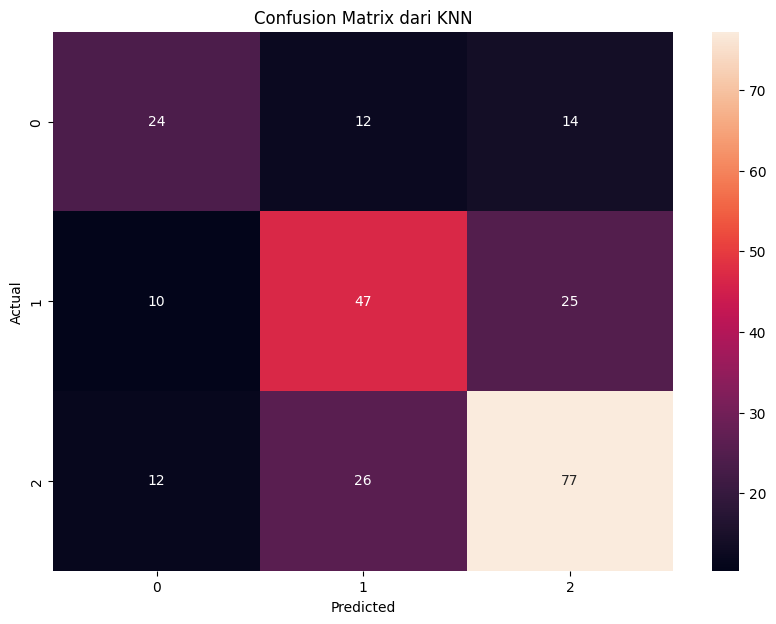


Rata-rata Metrik KNN:
Precision: 0.5985279364728902
Recall: 0.5983805668016193
F1 Score: 0.5978318622885223
Waktu Training: 1.5717668533325195 s


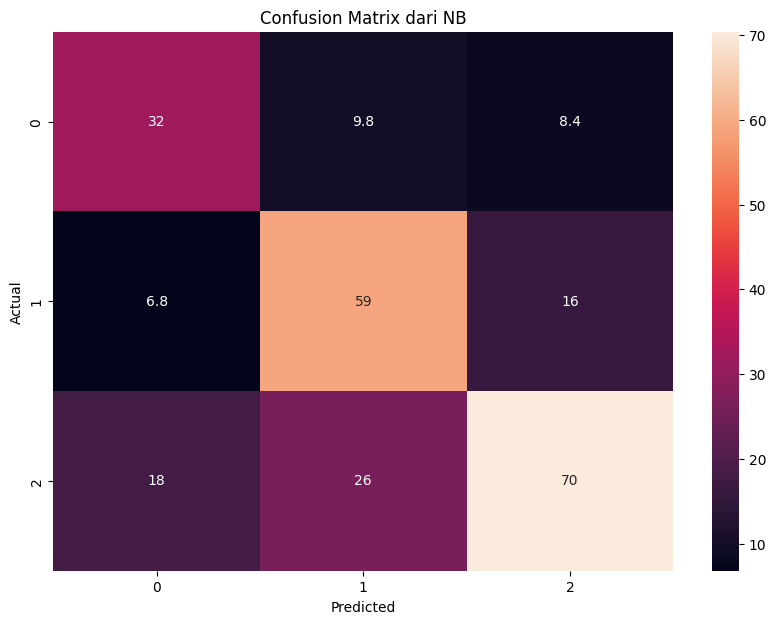


Rata-rata Metrik NB:
Precision: 0.6658589912341226
Recall: 0.654251012145749
F1 Score: 0.6548847509413454
Waktu Training: 0.9965033531188965 s


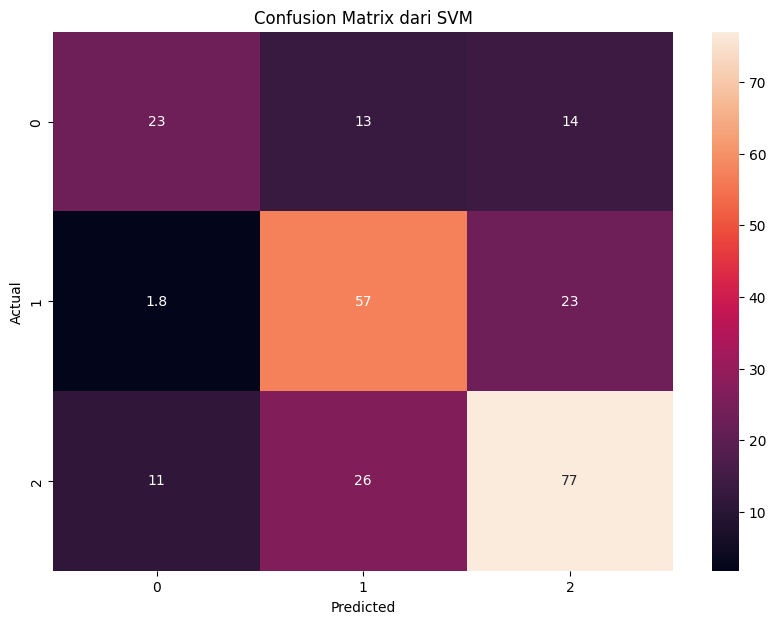


Rata-rata Metrik SVM:
Precision: 0.6405677535869098
Recall: 0.637246963562753
F1 Score: 0.6340843044606121
Waktu Training: 1.8542695045471191 s


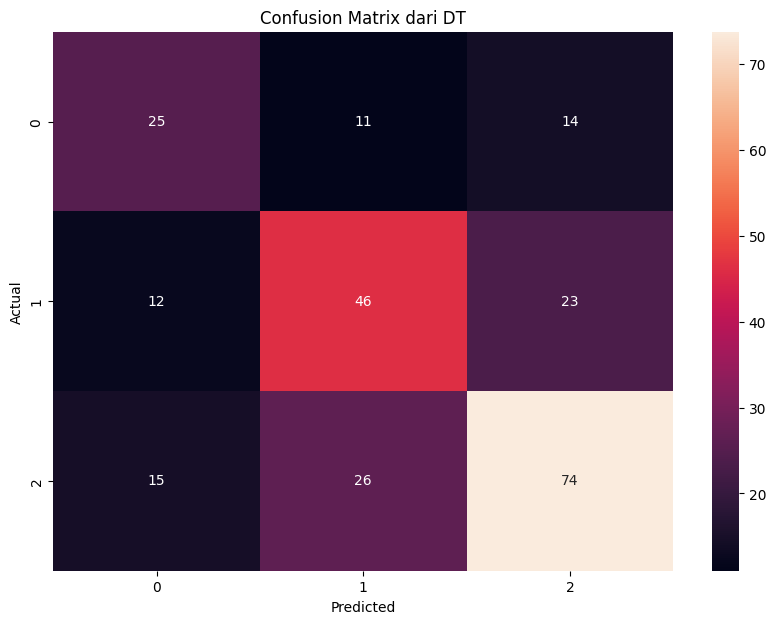


Rata-rata Metrik DT:
Precision: 0.5906520151778596
Recall: 0.5870445344129555
F1 Score: 0.5878559975038854
Waktu Training: 0.6011507511138916 s


In [694]:
models = {
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(gamma='auto'),
    'DT': DecisionTreeClassifier()
}

for model_name, model in models.items():
    fold = 0
    metrics = []
    conf_mat_sum = None
    start_time = time.time()
    for train_index, test_index in kfold.split(X_train, y_train):
        fold += 1
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fold, y_pred, average='weighted')
        metrics.append((precision, recall, f1_score))

        conf_mat = confusion_matrix(y_test_fold, y_pred)
        if conf_mat_sum is None:
            conf_mat_sum = conf_mat
        else:
            conf_mat_sum += conf_mat

    avg_conf_mat = conf_mat_sum / fold
    plt.figure(figsize=(10,7))
    sns.heatmap(avg_conf_mat, annot=True)
    plt.title(f'Confusion Matrix dari {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    end_time = time.time()
    metrics_mean = np.mean(metrics, axis=0)
    print(f'\nRata-rata Metrik {model_name}:')
    print(f'Precision: {metrics_mean[0]}')
    print(f'Recall: {metrics_mean[1]}')
    print(f'F1 Score: {metrics_mean[2]}')
    print(f'Waktu Training: {end_time - start_time} s')


In [652]:


# models = {
#     'KNN': KNeighborsClassifier(),
#     'NB': GaussianNB(),
#     'SVM': SVC(gamma='auto'),
#     'DT': DecisionTreeClassifier()
# }

# for model_name, model in models.items():
#     fold = 0
#     correct_classified_sum = 0
#     incorrect_classified_sum = 0
#     start_time = time.time()
#     for train_index, test_index in kfold.split(X_train, y_train):
#         fold += 1
#         X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_test_fold)


#         accuracy = accuracy_score(y_test_fold, y_pred)
#         correct_classified = accuracy * len(y_test_fold)
#         incorrect_classified = len(y_test_fold) - correct_classified
#         correct_classified_sum += correct_classified
#         incorrect_classified_sum += incorrect_classified

#     end_time = time.time()
#     print(f'\n{model_name}:')
#     print(f'Waktu Training: {end_time - start_time} s')
#     print(f'Correctly Classified: {correct_classified_sum / (fold * len(y_test_fold)) * 100}%')
#     print(f'Incorrectly Classified: {incorrect_classified_sum / (fold * len(y_test_fold)) * 100}%')



KNN:
Waktu Training: 0.18331646919250488 s
Correctly Classified: 59.83805668016194%
Incorrectly Classified: 40.16194331983806%

NB:
Waktu Training: 0.12345480918884277 s
Correctly Classified: 65.4251012145749%
Incorrectly Classified: 34.5748987854251%

SVM:
Waktu Training: 1.0026345252990723 s
Correctly Classified: 63.7246963562753%
Incorrectly Classified: 36.2753036437247%

DT:
Waktu Training: 0.15227127075195312 s
Correctly Classified: 59.10931174089069%
Incorrectly Classified: 40.89068825910931%


## Other models


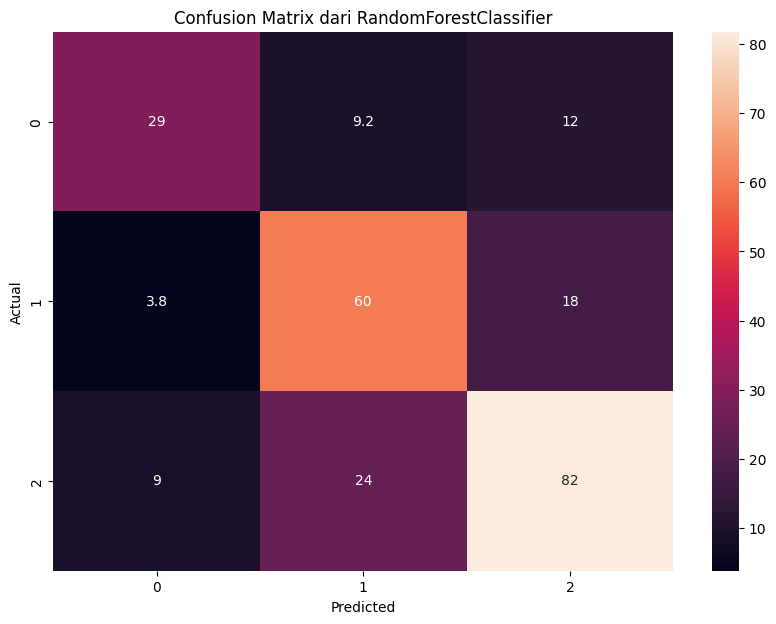


Rata-rata Metrik RandomForestClassifier:
Precision: 0.697257938706366
Recall: 0.6923076923076923
F1 Score: 0.6918572321910776
Waktu Training: 4.4084484577178955 s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 24
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

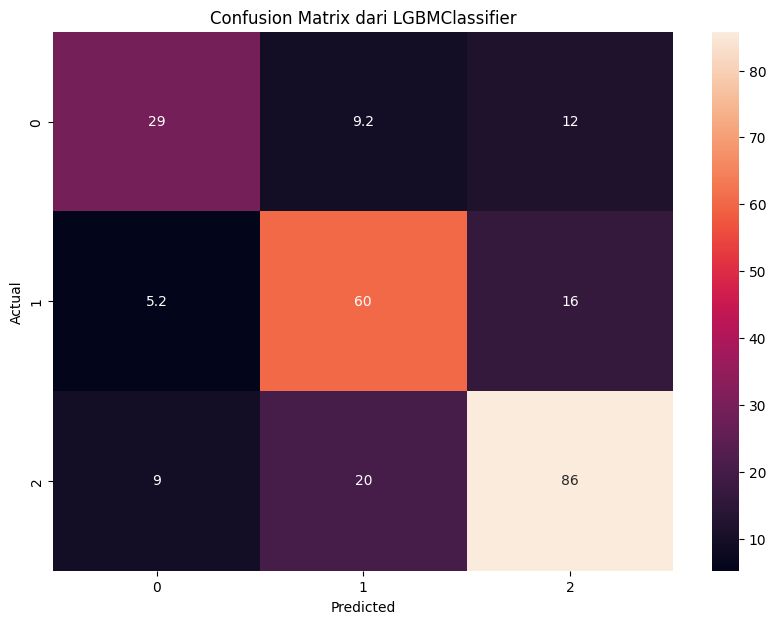


Rata-rata Metrik LGBMClassifier:
Precision: 0.7116873757589862
Recall: 0.7101214574898785
F1 Score: 0.7091423224973568
Waktu Training: 3.544149398803711 s


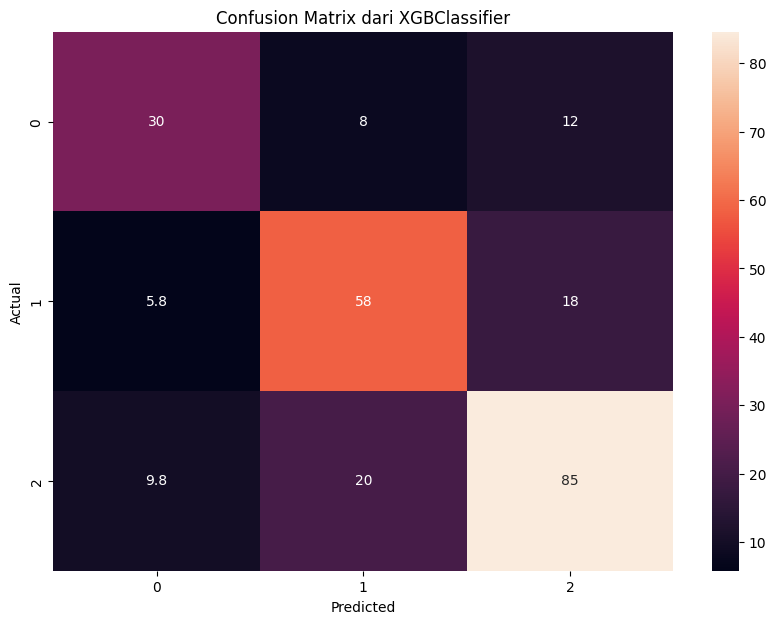


Rata-rata Metrik XGBClassifier:
Precision: 0.7038269255552317
Recall: 0.7020242914979757
F1 Score: 0.70166528077932
Waktu Training: 15.39786958694458 s


In [695]:
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'LGBMClassifier': LGBMClassifier(),
    'XGBClassifier': XGBClassifier()
}

for model_name, model in models.items():
    fold = 0
    metrics = []
    conf_mat_sum = None
    start_time = time.time()
    for train_index, test_index in kfold.split(X_train, y_train):
        fold += 1
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fold, y_pred, average='weighted')
        metrics.append((precision, recall, f1_score))

        conf_mat = confusion_matrix(y_test_fold, y_pred)
        if conf_mat_sum is None:
            conf_mat_sum = conf_mat
        else:
            conf_mat_sum += conf_mat

    avg_conf_mat = conf_mat_sum / fold
    plt.figure(figsize=(10,7))
    sns.heatmap(avg_conf_mat, annot=True)
    plt.title(f'Confusion Matrix dari {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    end_time = time.time()
    metrics_mean = np.mean(metrics, axis=0)
    print(f'\nRata-rata Metrik {model_name}:')
    print(f'Precision: {metrics_mean[0]}')
    print(f'Recall: {metrics_mean[1]}')
    print(f'F1 Score: {metrics_mean[2]}')
    print(f'Waktu Training: {end_time - start_time} s')


In [653]:
# models = {
#     'RandomForestClassifier': RandomForestClassifier(),
#     'LGBMClassifier': LGBMClassifier(),
#     'XGBClassifier': XGBClassifier()
# }

# for model_name, model in models.items():
#     fold = 0
#     correct_classified_sum = 0
#     incorrect_classified_sum = 0
#     start_time = time.time()
#     for train_index, test_index in kfold.split(X_train, y_train):
#         fold += 1
#         X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_test_fold)

#         # Calculate correctly and incorrectly classified instances
#         accuracy = accuracy_score(y_test_fold, y_pred)
#         correct_classified = accuracy * len(y_test_fold)
#         incorrect_classified = len(y_test_fold) - correct_classified
#         correct_classified_sum += correct_classified
#         incorrect_classified_sum += incorrect_classified

#     end_time = time.time()
#     print(f'\n{model_name}:')
#     print(f'Waktu Training: {end_time - start_time} s')
#     print(f'Correctly Classified: {correct_classified_sum / (fold * len(y_test_fold)) * 100}%')
#     print(f'Incorrectly Classified: {incorrect_classified_sum / (fold * len(y_test_fold)) * 100}%')



RandomForestClassifier:
Waktu Training: 2.9728689193725586 s
Correctly Classified: 69.79757085020243%
Incorrectly Classified: 30.20242914979757%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 24
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGB

## grid search for hyperparameter

In [670]:
# grid search untuk KNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, refit=True, verbose=2, cv=kfold)
grid_knn.fit(X_train, y_train)

# grid search untuk SVM
param_grid_svm = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=2, cv=kfold)
grid_svm.fit(X_train, y_train)

# grid search untuk Decision Tree
param_grid_dt = {'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, verbose=2, cv=kfold)
grid_dt.fit(X_train, y_train)

print("parameter terbaik dan skornya untuk KNN: ", grid_knn.best_params_, grid_knn.best_score_)
print("parameter terbaik dan skornya untuk SVM: ", grid_svm.best_params_, grid_svm.best_score_)
print("parameter terbaik dan skornya untuk Decision Tree: ", grid_dt.best_params_, grid_dt.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=5; total time=   0.0s
[CV] END ......................................n_neighbors=7; total time=   0.0s
[CV] END ......................................n_

In [672]:
# grid search untuk Random Forest
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2, cv=kfold)
grid_rf.fit(X_train, y_train)


# grid search untuk LGBM
param_grid_lgbm = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [-1, 10, 20]}
grid_lgbm = GridSearchCV(LGBMClassifier(), param_grid_lgbm, refit=True, verbose=2, cv=kfold)
grid_lgbm.fit(X_train, y_train)

# grid search untuk XGBM
param_grid_xgbm = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [6, 10, 15]}
grid_xgbm = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgbm, refit=True, verbose=2, cv=kfold)
grid_xgbm.fit(X_train, y_train)

print("parameter terbaik dan skornya untuk Random Forest: ", grid_rf.best_params_, grid_rf.best_score_)
print("parameter terbaik dan skornya untuk LGBM: ", grid_lgbm.best_params_, grid_lgbm.best_score_)
print("parameter terbaik dan skornya untuk XGBM: ", grid_xgbm.best_params_, grid_xgbm.best_score_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

### Optuna

In [658]:
# def objective(trial: Trial) -> float:
#     params_lgb = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 2, 25),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 500),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
#         'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
#     }

#     model = LGBMClassifier(**params_lgb)
#     return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

# sampler = TPESampler(seed=42)
# study = optuna.create_study(
#     study_name="lgbm_parameter_opt",
#     direction="maximize",
#     sampler=sampler,
# )
# study.optimize(objective, n_trials=50)
# print("Best Score:", study.best_value)
# print("Best trial:", study.best_trial.params)

## Model with best hyperparameter

### 3 basic models

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=9)
# scores_knn = cross_val_score(knn, X_train, y_train, cv=kfold)
# print('KNN: %f (%f)' % (scores_knn.mean(), scores_knn.std()))

# svm = SVC(C=1, gamma=0.1)
# scores_svm = cross_val_score(svm, X_train, y_train, cv=kfold)
# print('SVM: %f (%f)' % (scores_svm.mean(), scores_svm.std()))

# dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
# scores_dt = cross_val_score(dt, X_train, y_train, cv=kfold)
# print('Decision Tree: %f (%f)' % (scores_dt.mean(), scores_dt.std()))

In [ ]:
# knn.fit(X_train, y_train)
# y_pred_knn = knn.predict(X_test)

# svm.fit(X_train, y_train)
# y_pred_svm = svm.predict(X_test)

# dt.fit(X_train, y_train)
# y_pred_dt = dt.predict(X_test)


In [ ]:
# nb = GaussianNB()
# nb.fit(X_train, y_train)
# y_pred_nb = nb.predict(X_test)

In [696]:
# from sklearn.metrics import accuracy_score

# # Parameter terbaik untuk setiap model
# best_params = {
#     'KNN': {'n_neighbors': 9},
#     'SVM': {'C': 10, 'gamma': 0.1},
#     'DT': {'max_depth': 10, 'min_samples_split': 2}
# }

# models = {
#     'KNN': KNeighborsClassifier(**best_params['KNN']),
#     'SVM': SVC(**best_params['SVM']),
#     'DT': DecisionTreeClassifier(**best_params['DT'])
# }

# for model_name, model in models.items():
#     fold = 0
#     correct_classified_sum = 0
#     incorrect_classified_sum = 0
#     start_time = time.time()
#     for train_index, test_index in kfold.split(X_train, y_train):
#         fold += 1
#         X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_test_fold)

#         accuracy = accuracy_score(y_test_fold, y_pred)
#         correct_classified = accuracy * len(y_test_fold)
#         incorrect_classified = len(y_test_fold) - correct_classified
#         correct_classified_sum += correct_classified
#         incorrect_classified_sum += incorrect_classified

#     end_time = time.time()
#     print(f'\n{model_name}:')
#     print(f'Waktu Training: {end_time - start_time} s')
#     print(f'Correctly Classified: {correct_classified_sum / (fold * len(y_test_fold)) * 100}%')
#     print(f'Incorrectly Classified: {incorrect_classified_sum / (fold * len(y_test_fold)) * 100}%')



KNN:
Waktu Training: 0.44312191009521484 s
Correctly Classified: 60.24291497975709%
Incorrectly Classified: 39.75708502024292%

SVM:
Waktu Training: 0.7017478942871094 s
Correctly Classified: 65.26315789473685%
Incorrectly Classified: 34.73684210526316%

DT:
Waktu Training: 0.10670614242553711 s
Correctly Classified: 60.80971659919029%
Incorrectly Classified: 39.19028340080972%


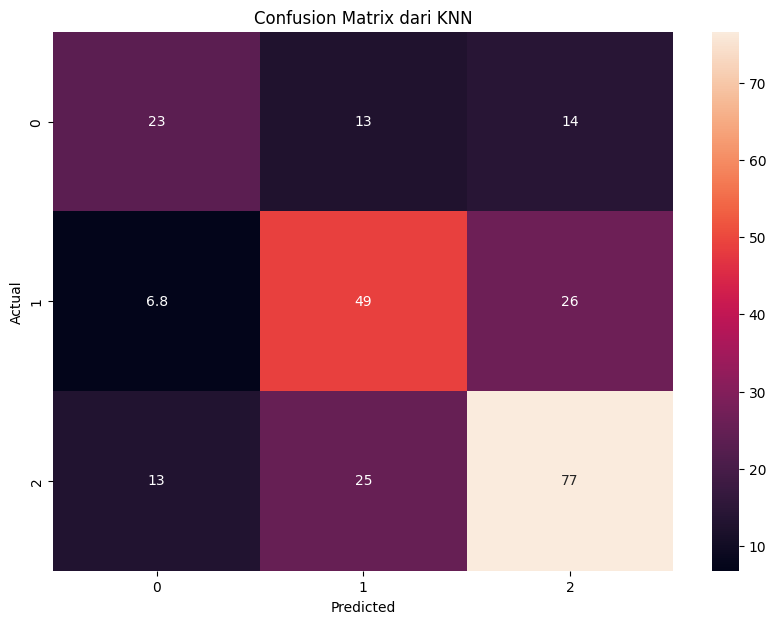


Rata-rata Metrik KNN:
Precision: 0.602977534794003
Recall: 0.6024291497975709
F1 Score: 0.6008210024361049
Waktu Training: 0.4626173973083496 s


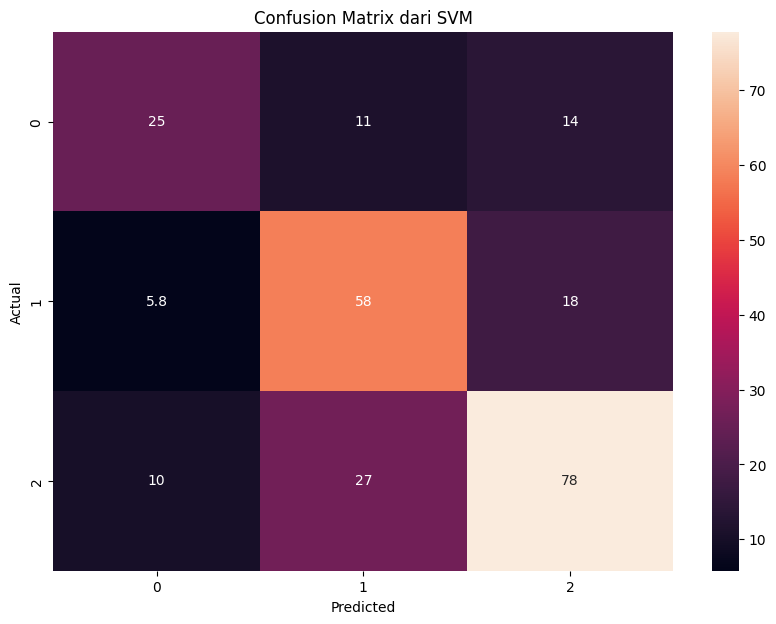


Rata-rata Metrik SVM:
Precision: 0.655878425769162
Recall: 0.6526315789473685
F1 Score: 0.6510099518925984
Waktu Training: 0.7073884010314941 s


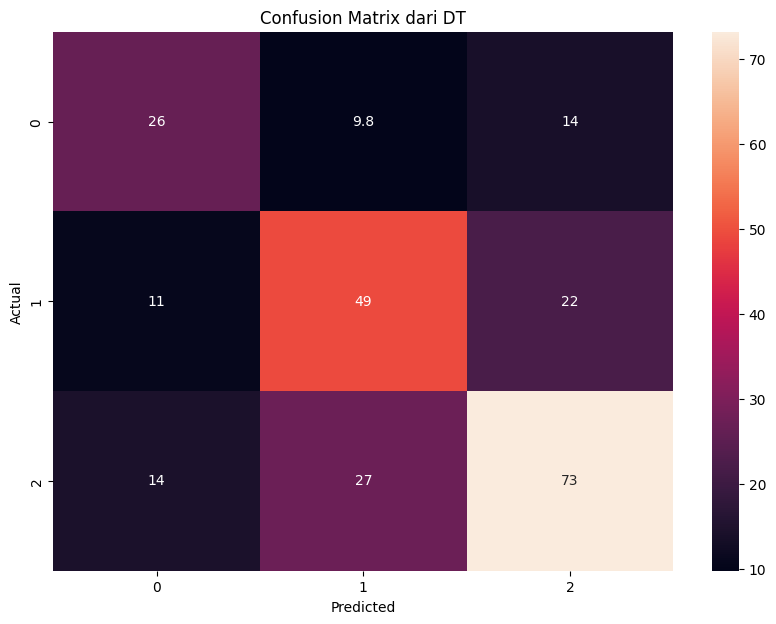


Rata-rata Metrik DT:
Precision: 0.6067225719992139
Recall: 0.603238866396761
F1 Score: 0.6039931591477788
Waktu Training: 0.3741915225982666 s


In [697]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Parameter terbaik untuk setiap model
best_params = {
    'KNN': {'n_neighbors': 9},
    'SVM': {'C': 10, 'gamma': 0.1},
    'DT': {'max_depth': 10, 'min_samples_split': 2}
}

models = {
    'KNN': KNeighborsClassifier(**best_params['KNN']),
    'SVM': SVC(**best_params['SVM']),
    'DT': DecisionTreeClassifier(**best_params['DT'])
}

for model_name, model in models.items():
    fold = 0
    metrics = []
    conf_mat_sum = None
    start_time = time.time()
    for train_index, test_index in kfold.split(X_train, y_train):
        fold += 1
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fold, y_pred, average='weighted')
        metrics.append((precision, recall, f1_score))

        conf_mat = confusion_matrix(y_test_fold, y_pred)
        if conf_mat_sum is None:
            conf_mat_sum = conf_mat
        else:
            conf_mat_sum += conf_mat

    avg_conf_mat = conf_mat_sum / fold
    plt.figure(figsize=(10,7))
    sns.heatmap(avg_conf_mat, annot=True)
    plt.title(f'Confusion Matrix dari {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    end_time = time.time()
    metrics_mean = np.mean(metrics, axis=0)
    print(f'\nRata-rata Metrik {model_name}:')
    print(f'Precision: {metrics_mean[0]}')
    print(f'Recall: {metrics_mean[1]}')
    print(f'F1 Score: {metrics_mean[2]}')
    print(f'Waktu Training: {end_time - start_time} s')


### Other models

In [ ]:
# rf = RandomForestClassifier(max_depth=20, n_estimators=100)
# scores_rf = cross_val_score(rf, X_train, y_train, cv=kfold)
# print('Random Forest: %f (%f)' % (scores_rf.mean(), scores_rf.std()))

# cb = CatBoostClassifier(depth=4, iterations=300, learning_rate=0.1, verbose=0)
# scores_cb = cross_val_score(cb, X_train, y_train, cv=kfold)
# print('CatBoost: %f (%f)' % (scores_cb.mean(), scores_cb.std()))

# lgbm = LGBMClassifier(learning_rate=0.01, max_depth=-1, n_estimators=300)
# scores_lgbm = cross_val_score(lgbm, X_train, y_train, cv=kfold)
# print('LGBM: %f (%f)' % (scores_lgbm.mean(), scores_lgbm.std()))

# xgbm = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=300, use_label_encoder=False, eval_metric='logloss')
# scores_xgbm = cross_val_score(xgbm, X_train, y_train, cv=kfold)
# print('XGBM: %f (%f)' % (scores_xgbm.mean(), scores_xgbm.std()))

In [ ]:
# lgbm = LGBMClassifier(
#     learning_rate=0.010568005734407887,
#     max_depth=17,
#     n_estimators=977,
#     num_leaves=113,
#     min_child_samples=26,
#     subsample=0.9489116040255952,
#     colsample_bytree=0.11186129294283109
# )
# scores_lgbm = cross_val_score(lgbm, X_train, y_train, cv=kfold)
# print('LGBM: %f (%f)' % (scores_lgbm.mean(), scores_lgbm.std()))

# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_test)


In [ ]:
# lgbm = LGBMClassifier()
# scores_lgbm = cross_val_score(lgbm, X_train, y_train, cv=kfold)
# print('LGBM: %f (%f)' % (scores_lgbm.mean(), scores_lgbm.std()))

# lgbm.fit(X_train, y_train)# y_pred = lgbm.predict(X_test)


In [674]:
# best_params = {
#     'RandomForestClassifier': {'max_depth': 20, 'n_estimators': 100},
#     'LGBMClassifier': {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100},
#     'XGBClassifier': {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
# }

# models = {
#     'RandomForestClassifier': RandomForestClassifier(**best_params['RandomForestClassifier']),
#     'LGBMClassifier': LGBMClassifier(**best_params['LGBMClassifier']),
#     'XGBClassifier': XGBClassifier(**best_params['XGBClassifier'])
# }

# for model_name, model in models.items():
#     fold = 0
#     correct_classified_sum = 0
#     incorrect_classified_sum = 0
#     start_time = time.time()
#     for train_index, test_index in kfold.split(X_train, y_train):
#         fold += 1
#         X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_test_fold)

#         accuracy = accuracy_score(y_test_fold, y_pred)
#         correct_classified = accuracy * len(y_test_fold)
#         incorrect_classified = len(y_test_fold) - correct_classified
#         correct_classified_sum += correct_classified
#         incorrect_classified_sum += incorrect_classified

#     end_time = time.time()
#     print(f'\n{model_name}:')
#     print(f'Waktu Training: {end_time - start_time} s')
#     print(f'Correctly Classified: {correct_classified_sum / (fold * len(y_test_fold)) * 100}%')
#     print(f'Incorrectly Classified: {incorrect_classified_sum / (fold * len(y_test_fold)) * 100}%')



RandomForestClassifier:
Waktu Training: 4.997223377227783 s
Correctly Classified: 69.47368421052632%
Incorrectly Classified: 30.526315789473685%
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 24
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

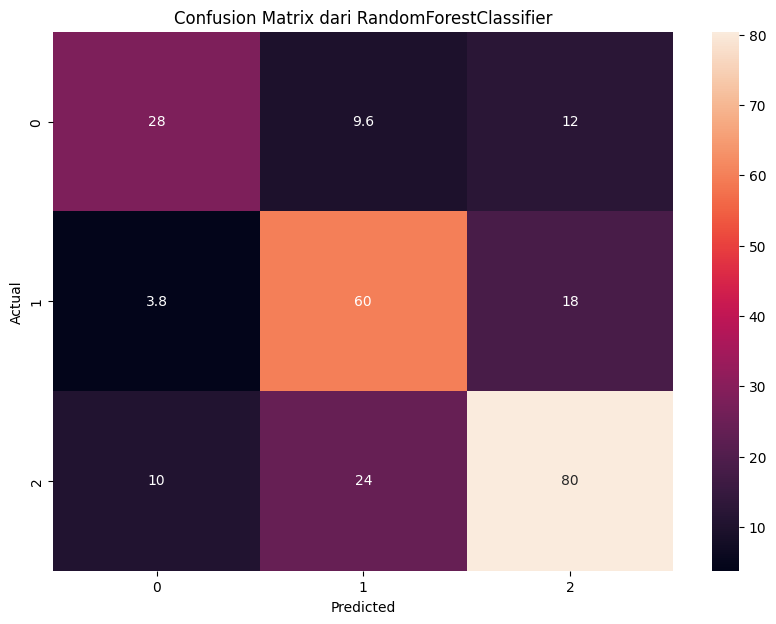


Rata-rata Metrik RandomForestClassifier:
Precision: 0.6854873673199705
Recall: 0.682591093117409
F1 Score: 0.6814739633152869
Waktu Training: 3.3844211101531982 s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 24
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Warning] No further splits with positive gain, best 

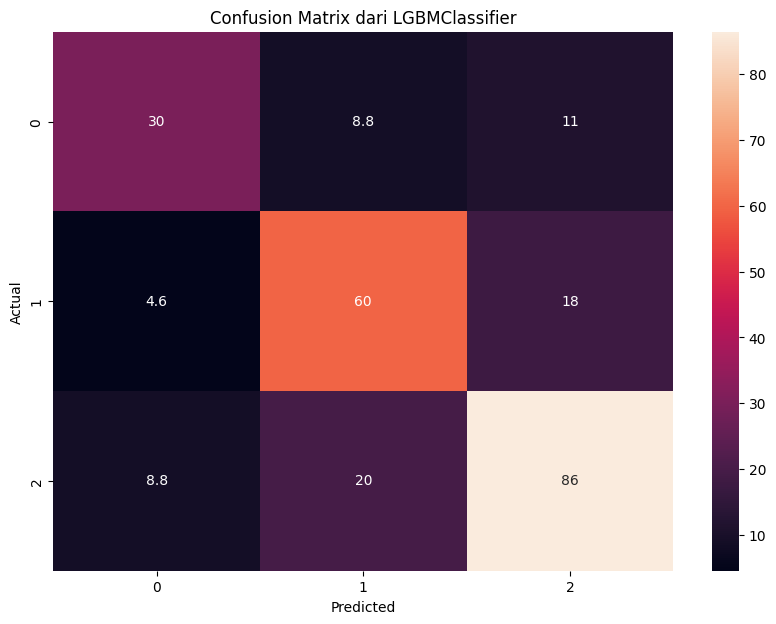


Rata-rata Metrik LGBMClassifier:
Precision: 0.7133464449825861
Recall: 0.7125506072874493
F1 Score: 0.7113970239572093
Waktu Training: 1.3821322917938232 s


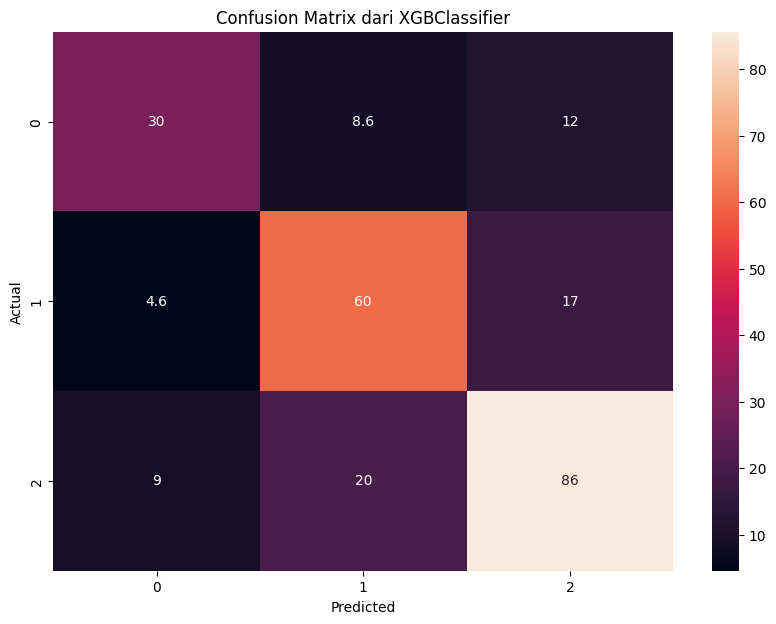


Rata-rata Metrik XGBClassifier:
Precision: 0.712702258599393
Recall: 0.7117408906882592
F1 Score: 0.7106774944905144
Waktu Training: 5.39737343788147 s


In [677]:
best_params = {
    'RandomForestClassifier': {'max_depth': 20, 'n_estimators': 100},
    'LGBMClassifier': {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100},
    'XGBClassifier': {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
}

models = {
    'RandomForestClassifier': RandomForestClassifier(**best_params['RandomForestClassifier']),
    'LGBMClassifier': LGBMClassifier(**best_params['LGBMClassifier']),
    'XGBClassifier': XGBClassifier(**best_params['XGBClassifier'])
}

for model_name, model in models.items():
    fold = 0
    metrics = []
    conf_mat_sum = None
    start_time = time.time()
    for train_index, test_index in kfold.split(X_train, y_train):
        fold += 1
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fold, y_pred, average='weighted')
        metrics.append((precision, recall, f1_score))

        conf_mat = confusion_matrix(y_test_fold, y_pred)
        if conf_mat_sum is None:
            conf_mat_sum = conf_mat
        else:
            conf_mat_sum += conf_mat

    avg_conf_mat = conf_mat_sum / fold
    plt.figure(figsize=(10,7))
    sns.heatmap(avg_conf_mat, annot=True)
    plt.title(f'Confusion Matrix dari {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    end_time = time.time()
    metrics_mean = np.mean(metrics, axis=0)
    print(f'\nRata-rata Metrik {model_name}:')
    print(f'Precision: {metrics_mean[0]}')
    print(f'Recall: {metrics_mean[1]}')
    print(f'F1 Score: {metrics_mean[2]}')
    print(f'Waktu Training: {end_time - start_time} s')


#Result

In [665]:
# scores_lgbm_series = pd.Series(y_pred)
# scores_lgbm_series = scores_lgbm_series.map({0: 'euthanized', 1: 'died', 2: 'lived'})

# submission_result_lgbm = pd.DataFrame({'id': test_robust['id'], 'outcome': scores_lgbm_series})
# submission_result_lgbm.to_csv('submission_lgbm.csv', index = False)

In [666]:
# scores_knn_series = pd.Series(y_pred_knn)
# scores_knn_series = scores_knn_series.map({0: 'euthanized', 1: 'died', 2: 'lived'})

# scores_svm_series = pd.Series(y_pred_svm)
# scores_svm_series = scores_svm_series.map({0: 'euthanized', 1: 'died', 2: 'lived'})

# scores_dt_series = pd.Series(y_pred_dt)
# scores_dt_series = scores_dt_series.map({0: 'euthanized', 1: 'died', 2: 'lived'})

# scores_nb_series = pd.Series(y_pred_nb)
# scores_nb_series = scores_nb_series.map({0: 'euthanized', 1: 'died', 2: 'lived'})

In [667]:
# submission_result_knn = pd.DataFrame({'id': test_robust['id'], 'outcome': scores_knn_series})
# submission_result_knn.to_csv('submission_knn.csv', index = False)

# submission_result_SVM = pd.DataFrame({'id': test_robust['id'], 'outcome': scores_svm_series})
# submission_result_SVM.to_csv('submission_svm.csv', index = False)

# submission_result_dt = pd.DataFrame({'id': test_robust['id'], 'outcome': scores_dt_series})
# submission_result_dt.to_csv('submission_dt.csv', index = False)

# submission_result_nb = pd.DataFrame({'id': test_robust['id'], 'outcome': scores_nb_series})
# submission_result_nb.to_csv('submission_nb.csv', index = False)